In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines
import pandas as pd
import time, os, sys, pickle
import seaborn as sns
from tqdm import tqdm
import svgutils.compose as sc
import IPython.display as ip
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color=sns.color_palette('colorblind'))
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar as mpl_colorbar

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# import bptt_rnn as bp  # RNN, learning algorithm, loss function etc
import bptt_rnn_mtl as bpm
import plot_routines as pr  # plotting functions & directly related
import plot_routines_mtl as prm
import rot_utilities as ru  # random utilies

%load_ext autoreload
%autoreload 2

prm.set_fontsize(12)

cpu


In [2]:
## Set sizes:
prm.set_fontsize(12)
plt.rcParams['axes.linewidth'] = 1.25  # defaul t0.8

# Example RNN training:
## Generate data:


In [19]:
# Data parameters dictionary
d_dict = { 'n_total': 1000,  # total number of data sequences
         'ratio_train': 0.8,
         'ratio_exp': 0.5,  # probabilities of switching between alpha nd beta
         'noise_scale': 0.15,
         't_delay': 2,
         't_stim': 2}

## Set training parameters:
t_dict = {}
t_dict['n_nodes'] = 20  # number of nodes in the RNN 
t_dict['learning_rate'] = 0.002  # algorithm lr
t_dict['bs'] = 1  # batch size
t_dict['n_epochs'] = 30  # training epochs
t_dict['l1_param'] = 1e-3  # L1 regularisation in loss function
t_dict['check_conv'] = False  # check for convergence (and abort if converged)
t_dict['conv_rel_tol'] = 5e-4  # assess convergence by relative difference between two epochs is smaller than this 


In [34]:
tmp0, tmp1 = bpm.generate_synt_data_general(n_total=d_dict['n_total'], t_delay=d_dict['t_delay'], t_stim=d_dict['t_stim'], 
                                        ratio_train=d_dict['ratio_train'], ratio_exp=d_dict['ratio_exp'],
                                        noise_scale=d_dict['noise_scale'], late_s2=False, early_match=False,
                                        nature_stim='periodic', task='dmc')
                    
x_train, y_train, x_test, y_test = tmp0
labels_train, labels_test = tmp1

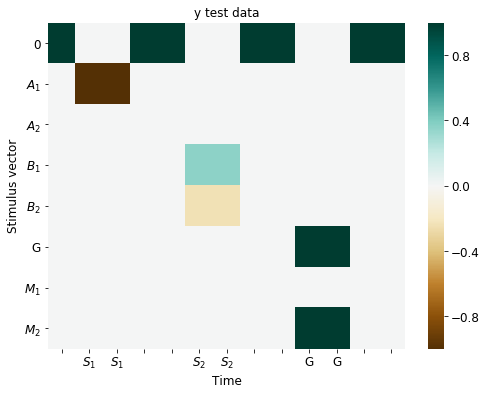

In [35]:
ax_true = plt.subplot(111)
k = np.where(labels_test == '2x')[0]
true_data = y_test[k, :, :]
if type(k) != int and len(k) > 1:  # if multiple samples; average
    true_data = true_data.mean(0)
prm.plot_example_trial(true_data.numpy(), ax=ax_true,
                     vmin=-1, c_map='BrBG')
ax_true.set_title("y test data"); #ax_true.set_ylabel('True data')

In [23]:
true_data.shape

torch.Size([13, 8])

## Train a RNN:

In [11]:
rnn = bpm.RNN_MTL(task='pred_dmc', nature_stim='onehot', n_nodes=t_dict['n_nodes'])  # Create RNN class
opt = torch.optim.SGD(rnn.parameters(), lr=t_dict['learning_rate'])  # call optimiser from pytorhc
rnn.set_info(param_dict={**d_dict, **t_dict})

In [ ]:
rnn = bpm.bptt_training(rnn=rnn, optimiser=opt, dict_training_params=t_dict,
                        x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test,
                        verbose=0, late_s2=False, use_gpu=False, simulated_annealing=False,
                        ratio_exp_array=None, save_state=True)

## Assess outcome:


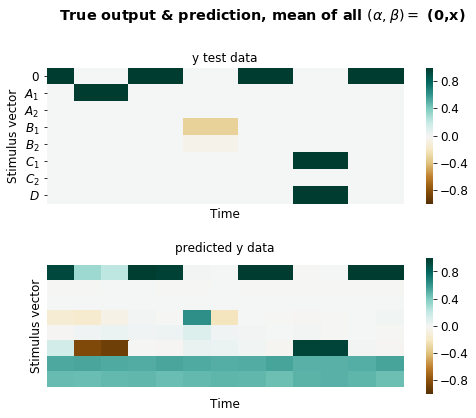

In [37]:
## Plot example test sample & prediction
k = np.where(labels_test == '0x')[0]
# print(f'Trial type: {labels_test[k]}')
pred = bpm.compute_full_pred(x_test[k,:,:], model=rnn)  # computed forward predictions

plt.rcParams['figure.figsize'] = (8,6 )
plt.subplots_adjust(hspace=0.4)
ax_true = plt.subplot(211)
true_data = y_test[k, :, :]
if type(k) != int and len(k) > 1:  # if multiple samples; average
    true_data = true_data.mean(0)
pr.plot_example_trial(true_data.numpy(), ax=ax_true,
            xticklabels=[], vmin=-1, c_map='BrBG')
ax_true.set_title("y test data"); #ax_true.set_ylabel('True data')

ax_pred = plt.subplot(212)
# if rnn.lin_output.out_features > rnn.n_stim:
pr.plot_example_trial(pred.mean(0).detach().numpy(), ax=ax_pred,
                      yticklabels=[],
               xticklabels=[], vmin=-1, c_map='BrBG')  # average if multiple samples
# else:
#     pr.plot_example_trial(pred.mean(0).detach().numpy(), ax=ax_pred,
#                xticklabels=double_time_labels_blank[1:])  # average if multiple samples
ax_pred.set_title("predicted y data"); #ax_pred.set_ylabel("Predictions");

plt.suptitle(r"True output & prediction, mean of all $(\alpha, \beta) =$ (" + labels_test[k][0][0] + ',' + labels_test[k][0][1] + ')', 
             weight='bold', y=1.02);
# plt.savefig('figures/prediction_unexpected.pdf', bbox_inches='tight')

In [26]:
list_rnns

[]

i_rnn: 3,  rnn-mnm_2021-05-09-0140.data
Trial type: ['11']
pred: 0.6260309934616088


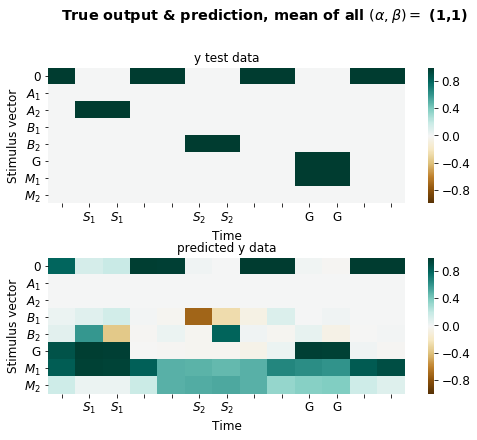

In [56]:
i_rnn += 1
# i_rnn = 0
# folder_rnn = '/home/thijs/repos/rotation/models/early_match/7525/dmc_task/onehot/sparsity_1e-03/dmc_only/'
folder_rnn = '/home/tplas/repos/rotation/models/7525/dmrc_task/periodic/sparsity_1e-03/pred_dmrc/'
# list_rnns = [x for x in os.listdir(folder_rnn) if ru.timestamp_min_date(rnn_name=x)]
list_rnns = os.listdir(folder_rnn)
filename = list_rnns[i_rnn]
rnn = ru.load_rnn(os.path.join(folder_rnn, filename))
print(f'i_rnn: {i_rnn}, ', filename)


## Plot example test sample & prediction
k = np.where(labels_test == '11')[0]
print(f'Trial type: {np.unique(labels_test[k])}')
pred = bpm.compute_full_pred(x_test[k,:,:], model=rnn)  # computed forward predictions

plt.rcParams['figure.figsize'] = (8,6 )
plt.subplots_adjust(hspace=0.4)
ax_true = plt.subplot(211)
true_data = y_test[k, :, :]

# part_spec_loss = bpm.specialisation_loss(y_est=pred, y_true=true_data, model=rnn)
# part_spec_loss = part_spec_loss.detach().numpy()
# print('part spec loss', part_spec_loss)

if type(k) != int and len(k) > 1:  # if multiple samples; average
    true_data = true_data.mean(0)
prm.plot_example_trial(true_data.numpy(), ax=ax_true, vmin=-1, c_map='BrBG')
ax_true.set_title("y test data"); #ax_true.set_ylabel('True data')

ax_pred = plt.subplot(212)
prm.plot_example_trial(pred.mean(0).detach().numpy(), ax=ax_pred, vmin=-1, c_map='BrBG')  # average if multiple samples
ax_pred.set_title("predicted y data"); #ax_pred.set_ylabel("Predictions");

plt.suptitle(r"True output & prediction, mean of all $(\alpha, \beta) =$ (" + labels_test[k][0][0] + ',' + labels_test[k][0][1] + ')', 
             weight='bold', y=1.02);
# plt.savefig('figures/prediction_unexpected.pdf', bbox_inches='tight')

for key in ['pred', 'dmc']:
    if key in rnn.test_loss_split.keys():
        print(f'{key}:', np.mean(rnn.test_loss_split[key][-5:]))

# full_pred = bpm.compute_full_pred(input_data=x_test, model=rnn)  # computed forward predictions
# spec_loss = bpm.specialisation_loss(y_est=full_pred, y_true=y_test, model=rnn)
# spec_loss = spec_loss.detach().numpy()
# print('spec loss', spec_loss)
# print('reg loss', bpm.regularisation_loss(model=rnn))

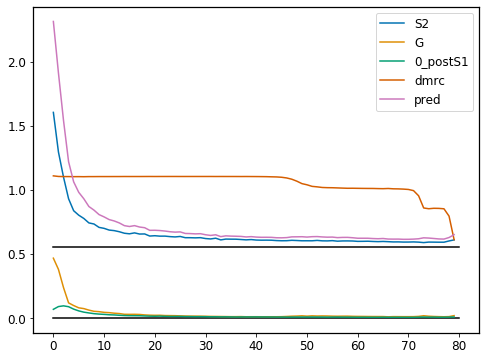

In [60]:
plt.plot([0, 80], [0, 0],c='k')
plt.plot([0, 80], [5/9, 5/9],c='k')
for kk in ['S2', 'G', '0_postS1', 'dmrc', 'pred']:
    plt.plot(rnn.test_loss_split[kk], label=kk)
plt.legend()

# Figure 1:

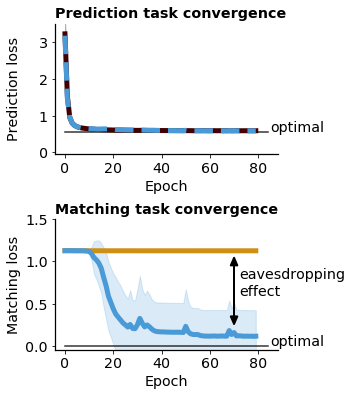

In [106]:

prm.set_fontsize(14.3)
fig, ax = plt.subplots(2, 1, figsize=(4, 6), gridspec_kw={'hspace': 0.5})
optimal_pred = -0.25 * (3 * np.log(0.75) + np.log(0.25))
ax[0].plot([0, 84], [optimal_pred, optimal_pred], c='k', alpha=0.8)
prm.plot_effect_eavesdropping_learning(task='dmc', ratio_exp_str='7525', nature_stim='onehot',
                                       sparsity_str='1e-03', ax=ax[0], plot_legend=False,
                                       plot_std=True, plot_indiv=False, plot_spec=False,
                                       plot_title=False)
ax[0].text(s='optimal', x=85, y=optimal_pred)
ax[0].set_ylabel('Prediction loss')
ax[0].set_title('Prediction task convergence', fontdict={'weight': 'bold'}, loc='left')
# plt.savefig('figures/nips/fig1_prediction_task.svg', bbox_inches='tight')


optimal_cat = 0
naive_cat = 2 * optimal_pred
ax[1].plot([0, 84], [optimal_cat, optimal_cat], c='k', alpha=0.8)
# ax[1].plot([0, 84], [naive_cat, naive_cat], c='k', alpha=0.8)
prm.plot_effect_eavesdropping_learning(task='dmc', ratio_exp_str='7525', nature_stim='onehot',
                                       sparsity_str='1e-03', ax=ax[1], plot_legend=False,
                                       plot_std=True, plot_indiv=False, plot_pred=False,
                                      plot_title=False)
ax[1].text(s='optimal', x=85, y=optimal_cat)
# ax[1].text(s='naive', x=85, y=naive_cat)
plt.arrow(70, 0.65, 0, 0.4, head_width=3, head_length=0.1, linewidth=1.5, 
          color='k', length_includes_head=True)
plt.arrow(70, 0.65, 0, -0.4, head_width=3, head_length=0.1, linewidth=1.5, 
          color='k', length_includes_head=True)
ax[1].text(s='eavesdropping\neffect', x=72, y=0.6)
ax[1].set_ylabel('Matching loss')
ax[1].set_title('Matching task convergence', fontdict={'weight': 'bold'}, loc='left')

fig.align_ylabels(axs=[ax[0], ax[1]])

plt.savefig('figures/nips/fig1_prediction_and_categorisation_task.svg', bbox_inches='tight')

In [110]:
sc.Figure('7cm', '4cm',
          sc.Panel(sc.SVG('figures/nips/fig1_prediction_and_categorisation_task.svg').scale(0.28).move(161.3, 40)),
          sc.Panel(sc.SVG('figures/nips/fig1_schematic.svg').scale(1).move(0, 0))
                  ).save('figures/nips/fig1_full_v2.svg')
ip.SVG('figures/nip/fig1_full_v2.svg')

ExpatError: not well-formed (invalid token): line 1, column 7

# Check some other folders:


EARLY MATCH CORRECTED LIST DIR


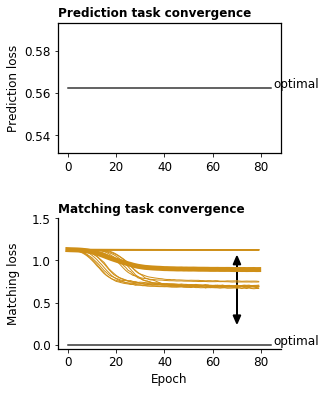

In [369]:
## Early match (eg MNM prompted during S2 presentation)
## (This is done by changing the folder name in prm.plot_effect_eavesdropping_learning())

# prm.set_fontsize(14.3)
fig, ax = plt.subplots(2, 1, figsize=(4, 6), gridspec_kw={'hspace': 0.5})
optimal_pred = -0.25 * (3 * np.log(0.75) + np.log(0.25))
ax[0].plot([0, 84], [optimal_pred, optimal_pred], c='k', alpha=0.8)
# prm.plot_effect_eavesdropping_learning(task='dmc', ratio_exp_str='7525', nature_stim='onehot',
#                                        sparsity_str='1e-03', ax=ax[0], plot_legend=False,
#                                        plot_std=True, plot_indiv=False, plot_spec=False,
#                                        plot_title=False)
ax[0].text(s='optimal', x=85, y=optimal_pred)
ax[0].set_ylabel('Prediction loss')
ax[0].set_title('Prediction task convergence', fontdict={'weight': 'bold'}, loc='left')
# plt.savefig('figures/nips/fig1_prediction_task.svg', bbox_inches='tight')


optimal_cat = 0
naive_cat = 2 * optimal_pred
ax[1].plot([0, 84], [optimal_cat, optimal_cat], c='k', alpha=0.8)
# ax[1].plot([0, 84], [naive_cat, naive_cat], c='k', alpha=0.8)
prm.plot_effect_eavesdropping_learning(task='dmc', ratio_exp_str='7525', nature_stim='onehot',
                                       sparsity_str='1e-03', ax=ax[1], plot_legend=False,
                                       plot_std=False, plot_indiv=True, plot_pred=False,
                                      plot_title=False)
ax[1].text(s='optimal', x=85, y=optimal_cat)
# ax[1].text(s='naive', x=85, y=naive_cat)
plt.arrow(70, 0.65, 0, 0.4, head_width=3, head_length=0.1, linewidth=1.5, 
          color='k', length_includes_head=True)
plt.arrow(70, 0.65, 0, -0.4, head_width=3, head_length=0.1, linewidth=1.5, 
          color='k', length_includes_head=True)
# ax[1].text(s='eavesdropping\neffect', x=72, y=0.6)
ax[1].set_ylabel('Matching loss')
ax[1].set_title('Matching task convergence', fontdict={'weight': 'bold'}, loc='left')

fig.align_ylabels(axs=[ax[0], ax[1]])


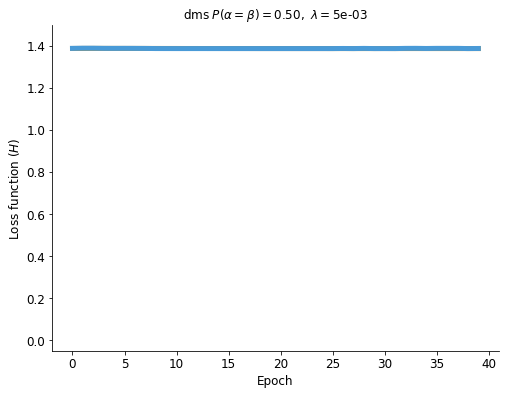

In [408]:
## 5050 does not learn.
prm.plot_effect_eavesdropping_learning(task='dms', ratio_exp_str='5050', nature_stim='onehot',
                                       sparsity_str='5e-03', ax=None, plot_legend=False,
                                       plot_std=False, plot_indiv=True, plot_pred=False)

## Check single RNN

In [12]:
(x_train, y_train, x_test, y_test), (labels_train, labels_test) = bpm.generate_synt_data_general(n_total=1000, t_delay=2, t_stim=2,
                               ratio_train=0.8, ratio_exp=0.75,
                               noise_scale=0.05, late_s2=False,
                               nature_stim='onehot', task='dmc')

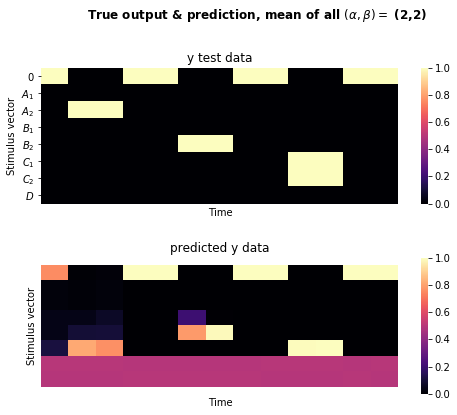

In [18]:
i_rnn =0
folder_comb = '/home/thijs/repos/rotation/models/sweep_n_nodes/7525/dmc_task/onehot/sparsity_5e-03/25_nodes/pred_only'
filename = os.listdir(folder_comb)[i_rnn]
rnn = ru.load_rnn(os.path.join(folder_comb, filename))

## Plot example test sample & prediction
k = np.where(labels_test == '22')[0]
# print(f'Trial type: {labels_test[k]}')
pred = bpm.compute_full_pred(x_test[k,:,:], model=rnn)  # computed forward predictions

plt.rcParams['figure.figsize'] = (8,6 )
plt.subplots_adjust(hspace=0.4)
ax_true = plt.subplot(211)
true_data = y_test[k, :, :]
if type(k) != int and len(k) > 1:  # if multiple samples; average
    true_data = true_data.mean(0)
pr.plot_example_trial(true_data.numpy(), ax=ax_true,
            xticklabels=[])
ax_true.set_title("y test data"); #ax_true.set_ylabel('True data')

ax_pred = plt.subplot(212)
# if rnn.lin_output.out_features > rnn.n_stim:
pr.plot_example_trial(pred.mean(0).detach().numpy(), ax=ax_pred,
                      yticklabels=[],
               xticklabels=[])  # average if multiple samples
# else:
#     pr.plot_example_trial(pred.mean(0).detach().numpy(), ax=ax_pred,
#                xticklabels=double_time_labels_blank[1:])  # average if multiple samples
ax_pred.set_title("predicted y data"); #ax_pred.set_ylabel("Predictions");

plt.suptitle(r"True output & prediction, mean of all $(\alpha, \beta) =$ (" + labels_test[k][0][0] + ',' + labels_test[k][0][1] + ')', 
             weight='bold', y=1.02);
# plt.savefig('figures/prediction_unexpected.pdf', bbox_inches='tight')

# Figure 2:


In [139]:
## Check how many network simulations we have per condition
ru.count_datasets_sparsity_sweep()

/home/thijs/repos/rotation/models/7525/dmrc_task/periodic/sparsity_0e+00 does not have equal number of trainings: [20. 40.]
/home/thijs/repos/rotation/models/7525/dmrc_task/periodic/sparsity_1e-06 does not have equal number of trainings: [20. 40.]
/home/thijs/repos/rotation/models/7525/dmrc_task/periodic/sparsity_5e-06 does not have equal number of trainings: [20. 40.]
/home/thijs/repos/rotation/models/7525/dmrc_task/periodic/sparsity_1e-05 does not have equal number of trainings: [20. 40.]
/home/thijs/repos/rotation/models/7525/dmrc_task/periodic/sparsity_5e-05 does not have equal number of trainings: [20. 40.]
/home/thijs/repos/rotation/models/7525/dmrc_task/periodic/sparsity_1e-04 does not have equal number of trainings: [20. 40.]
/home/thijs/repos/rotation/models/7525/dmrc_task/periodic/sparsity_5e-04 does not have equal number of trainings: [20. 40.]
/home/thijs/repos/rotation/models/7525/dmrc_task/periodic/sparsity_1e-03 does not have equal number of trainings: [20. 40.]
/home/th

,sparsity,sparsity_str,dmrc_periodic,dmc_periodic,dmc_onehot,dms_periodic,dms_onehot,dmrs_periodic
0,0.000000,0e+00,40,40,40,40,40,40
1,0.000001,1e-06,40,40,40,40,40,40
2,0.000005,5e-06,40,40,40,40,40,40
3,0.000010,1e-05,40,40,40,40,40,40
4,0.000050,5e-05,40,40,40,40,40,40
5,0.000100,1e-04,40,40,40,40,40,40
6,0.000500,5e-04,40,40,40,40,40,40
7,0.001000,1e-03,40,40,40,40,40,40
8,0.005000,5e-03,40,40,40,40,40,40
9,0.010000,1e-02,40,40,40,40,40,40


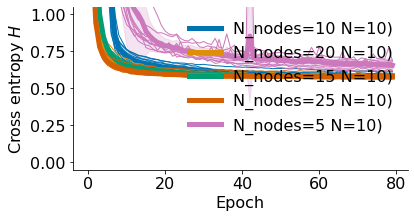

In [79]:
## Convergence for n nodes sweep
prm.plot_n_nodes_convergence(plot_indiv=True,
  parent_folder='/home/thijs/repos/rotation/models/sweep_n_nodes/7525/dms_task/onehot/sparsity_1e-04/')

dmc onehot
dms onehot
dmc periodic
dms periodic
dmrc periodic
dmrs periodic


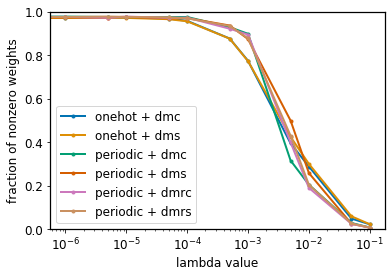

In [5]:
## Sparsity vs fraction non zero weights:
for tmp1 in ['onehot', 'periodic']:
    for tmp2 in ['dmc', 'dms', 'dmrc', 'dmrs']:
        if tmp1 == 'onehot':
            if 'r' in tmp2:
                continue
        nz_df, nz_array, spars_arr = ru.create_nonzero_mapping_df(type_task=tmp2, nature_stim=tmp1)
        sorting_spars = np.argsort(spars_arr)
        spars_arr = spars_arr[sorting_spars]
        nz_array = nz_array[sorting_spars]
        plt.plot(spars_arr, nz_array, marker='.', linewidth=2, label=f'{tmp1} + {tmp2}')
        plt.xscale('log')
        plt.xlabel('lambda value')
        plt.ylabel('fraction of nonzero weights')
        plt.ylim([0, 1])
        plt.legend()

0.00010334649564653764 mtl stl
0.016880932087628427 late s2
8.857457687863547e-05 mtl stl
Cutting of DF because of empty rows
Cutting of DF because of empty rows
5.333285565342521 ['dmc'] ['onehot']


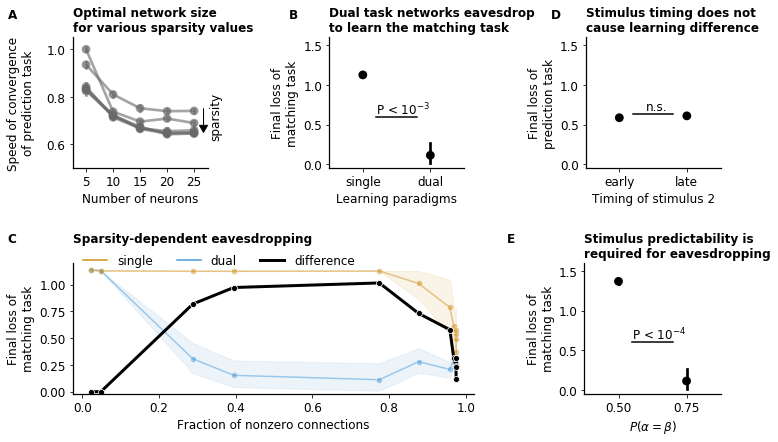

In [586]:
fig = plt.figure(constrained_layout=False, figsize=(9, 5.5))
gs_top = fig.add_gridspec(ncols=3, nrows=1, bottom=0.62, top=0.95, left=0, right=1, wspace=0.9)
gs_bottom_l = fig.add_gridspec(ncols=1, nrows=1, bottom=0.05, top=0.38, left=0, right=0.62, wspace=0.9)
gs_bottom_r = fig.add_gridspec(ncols=1, nrows=1, bottom=0.05, top=0.38, left=0.79, right=1, wspace=0.9)

ax_top, ax_bottom = {}, {}
for ii in range(3):
    ax_top[ii] = fig.add_subplot(gs_top[ii])
ax_bottom_r = fig.add_subplot(gs_bottom_r[0])
ax_bottom_l = fig.add_subplot(gs_bottom_l[0])
# for ii in range(2):
#     ax_bottom[ii] = fig.add_subplot(gs_bottom[ii])
prm.plot_n_nodes_sweep_multiple(method='integral', ax=ax_top[0])
prm.plot_stl_mtl_comparison(method='final_loss', ax=ax_top[1])
prm.plot_late_s2_comparison(method='final_loss', ax=ax_top[2])
prm.plot_7525_5050_comparison(method='final_loss', ax=ax_bottom_r)

df = prm.plot_learning_efficiency(plot_difference=False, method='final_loss', task_list=['dmc'],
                                  nature_stim_list=['onehot'], ax=ax_bottom_l, indicate_sparsity=False,
                                  new_x_axis_df=nz_df)
df = prm.plot_learning_efficiency(plot_difference=True, method='final_loss', task_list=['dmc'],
                                  nature_stim_list=['onehot'], ax=ax_bottom_l, indicate_sparsity=True,
                                  plot_custom_legend=True, plot_title=True, leg_cols=3,
                                  new_x_axis_df=nz_df, leg_anchor=(0, 1.15))

ax_top[0].text(s='A', x=-2.9, y=1.13, fontdict={'weight': 'bold'})
ax_top[0].text(s='B', x=7.5, y=1.13, fontdict={'weight': 'bold'})
ax_top[0].text(s='D', x=17.2, y=1.13, fontdict={'weight': 'bold'})
ax_top[0].text(s='C', x=-2.9, y=0.19, fontdict={'weight': 'bold'})
ax_top[0].text(s='E', x=15.6, y=0.19, fontdict={'weight': 'bold'})

fig.align_ylabels(axs=[ax_top[0], ax_bottom_l])
fig.align_ylabels(axs=[ax_top[2], ax_bottom_r])

plt.savefig('figures/nips/fig2-homework_v2.pdf', bbox_inches='tight')

In [34]:
## Extra bit on gridsweep sparsity vs n nodes:

learn_eff_df_grid = ru.calculate_all_learning_eff_indices_gridsweep()
learn_eff_df_grid

,task,nature_stim,loss_comp,setting,learning_eff,sparsity,n_nodes
0,dmc,onehot,dmc_single,single,1.386295,0.0,5.0
1,dmc,onehot,dmc_single,single,1.386295,0.0,5.0
2,dmc,onehot,dmc_single,single,1.386295,0.0,5.0
3,dmc,onehot,dmc_single,single,1.386308,0.0,5.0
4,dmc,onehot,dmc_single,single,1.386334,0.0,5.0
...,...,...,...,...,...,...,...
1795,dmc,onehot,dmc_multi,multi,1.139926,0.1,50.0
1796,dmc,onehot,dmc_multi,multi,1.134159,0.1,50.0
1797,dmc,onehot,dmc_multi,multi,1.136675,0.1,50.0
1798,dmc,onehot,dmc_multi,multi,1.139950,0.1,50.0


Cutting of DF because of empty rows


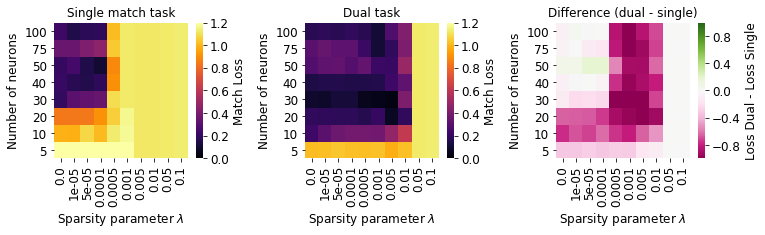

In [65]:
prm.plot_learning_efficiency_matrix_sweep()

Cutting of DF because of empty rows
2.090743818886576 ['dmc'] ['onehot']
Cutting of DF because of empty rows
Cutting of DF because of empty rows
5.479614048933612 ['dmc'] ['onehot']
Cutting of DF because of empty rows
Cutting of DF because of empty rows
6.527746847308706 ['dmc'] ['onehot']
Cutting of DF because of empty rows
Cutting of DF because of empty rows
4.6628954802402305 ['dmc'] ['onehot']
Cutting of DF because of empty rows
Cutting of DF because of empty rows
3.533081921709236 ['dmc'] ['onehot']
Cutting of DF because of empty rows
Cutting of DF because of empty rows
2.479279126070439 ['dmc'] ['onehot']
Cutting of DF because of empty rows
Cutting of DF because of empty rows
3.7878386416498095 ['dmc'] ['onehot']
Cutting of DF because of empty rows
Cutting of DF because of empty rows
3.4268721093769425 ['dmc'] ['onehot']
Cutting of DF because of empty rows
zep


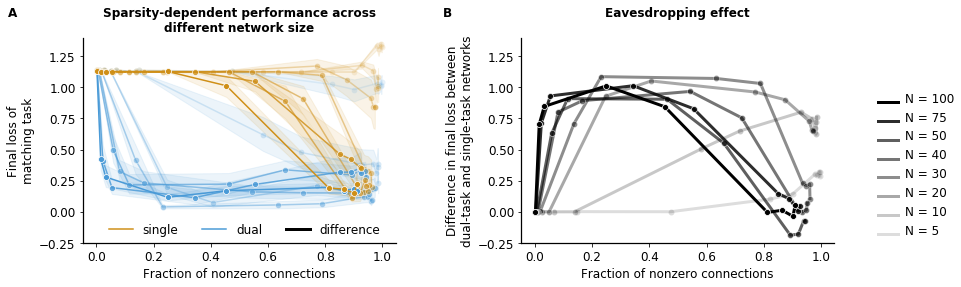

In [135]:
# ax = plt.subplot(111)
fig = plt.figure(constrained_layout=False, figsize=(12, 3))
gs_plots = fig.add_gridspec(ncols=2, nrows=1, left=0, right=0.87, top=0.95, bottom=0, wspace=0.4)
gs_leg = fig.add_gridspec(ncols=1, nrows=1, left=0.92, right=1, top=1, bottom=0)

save_fig = True
plot_nz_axis = True
bool_diff = False
use_gridsweep = True
ax = {ii: fig.add_subplot(gs_plots[ii]) for ii in range(2)}
ax_leg = fig.add_subplot(gs_leg[0])
n_nodes_list = [5, 10, 20, 30, 40, 50, 75, 100]
for i_node, n_nodes in enumerate(n_nodes_list):
    gridsweep_n_nodes = f'n_nodes_{n_nodes}'
    if plot_nz_axis:
        nz_df, _, __ = ru.create_nonzero_mapping_df(type_task='dmc', nature_stim='onehot', 
                                    use_gridsweep_rnns=use_gridsweep, gridsweep_n_nodes=gridsweep_n_nodes)
    else:
        nz_df = None
    for bool_diff in [True, False]:
        df = prm.plot_learning_efficiency(plot_difference=bool_diff, method='final_loss', 
                                        task_list=['dmc'], nature_stim_list=['onehot'], ax=ax[1 if bool_diff else 0],
                                        plot_custom_legend=np.logical_and(bool_diff == False, i_node == len(n_nodes_list) - 1), 
                                        leg_anchor=(0.05, 0.15), leg_cols=3,
                                        new_x_axis_df=nz_df,
                                        use_gridsweep_rnns=use_gridsweep, gridsweep_n_nodes=gridsweep_n_nodes)

    if use_gridsweep is False:
        break

    ## make legend
    y_pos = 0.04 + (i_node / len(n_nodes_list)) * 0.7
    x_pos = 0

    ax_leg.plot([x_pos, x_pos + 0.3], [y_pos, y_pos], linewidth=3, c='k', 
                alpha=np.power((n_nodes / 100), 0.67))  # same as in prm.plot_learning_efficiency()

    ax_leg.text(s=f'N = {n_nodes}', x=x_pos + 0.4, y=y_pos, ha='left')

for i_plot in range(2):
    ax[i_plot].set_ylim([-0.25, 1.4])

ax[1].set_ylabel('Difference in final loss between\ndual-task and single-task networks')
ax[0].set_title('Sparsity-dependent performance across\ndifferent network size', fontdict={'weight': 'bold'})
ax[1].set_title('Eavesdropping effect\n', fontdict={'weight': 'bold'})
ax[0].text(s='A', x=-0.31, y=1.57, fontdict={'weight': 'bold'})
ax[0].text(s='B', x=1.21, y=1.57, fontdict={'weight': 'bold'})
prm.naked(ax_leg)
ax_leg.set_xlim([0, 1])
ax_leg.set_ylim([0, 1])

if save_fig:
    plt.savefig('figures/nips/fig2-supp_networksize_sparsity_sweep.pdf', bbox_inches='tight')

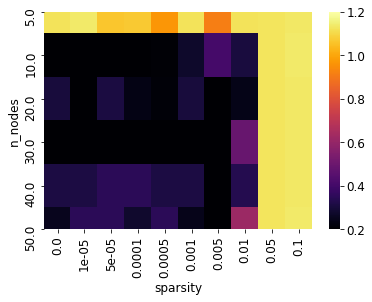

In [64]:
tmp_df = learn_eff_df_grid.drop(columns=['task', 'nature_stim', 'setting'])
tmp_df = tmp_df[tmp_df['loss_comp'] == 'dmc_multi']

tmp_df = tmp_df.groupby(['loss_comp', 'sparsity', 'n_nodes']).mean()
tmp_df = tmp_df.reset_index()
tmp_mat = tmp_df.pivot(index='n_nodes', columns='sparsity', values='learning_eff')
sns.heatmap(data=tmp_mat, vmin=0.2, vmax=1.2, cmap='inferno')

# Figure 4:

Cutting of DF because of empty rows
Cutting of DF because of empty rows
Cutting of DF because of empty rows
Cutting of DF because of empty rows
Cutting of DF because of empty rows
Cutting of DF because of empty rows
Cutting of DF because of empty rows
5.333285565342521 ['dmc'] ['onehot']
Cutting of DF because of empty rows
1.9392361710818171 ['dmc'] ['periodic']
Cutting of DF because of empty rows
0.43684048190402475 ['dmrc'] ['periodic']
Cutting of DF because of empty rows
4.418732687113806 ['dms'] ['onehot']
Cutting of DF because of empty rows
1.1422101901153414 ['dms'] ['periodic']
Cutting of DF because of empty rows
0.7895927545808564 ['dmrs'] ['periodic']


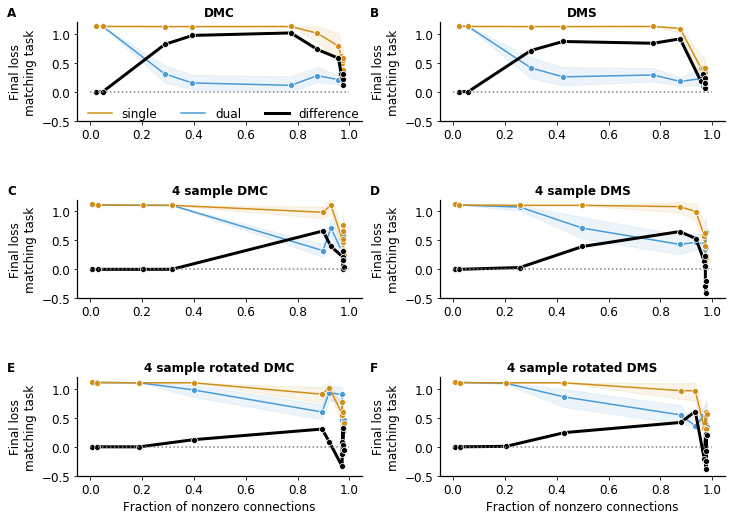

In [96]:
fig = plt.figure(constrained_layout=False, figsize=(9, 7))
gs_left = fig.add_gridspec(ncols=1, nrows=3, bottom=0.05, top=0.95, left=0, right=0.44, wspace=0.7, hspace=0.8)
gs_right = fig.add_gridspec(ncols=1, nrows=3, bottom=0.05, top=0.95, left=0.56, right=1, wspace=0.7, hspace=0.8)

ax_left, ax_right = {}, {}
for ii in range(3):
    ax_left[ii] = fig.add_subplot(gs_left[ii])
    ax_right[ii] = fig.add_subplot(gs_right[ii])
    
method = 'final_loss'    
save_fig = True
plot_nz_axis = True


for bool_diff in [False, True]:
    i_plot = 0
    for type_task in ['dmc', 'dmrc', 'dms', 'dmrs']:
        for nature_stim in ['onehot', 'periodic']:
            if nature_stim == 'onehot':
                if 'r' in type_task:
                    continue
            if i_plot < 3:
                curr_ax = ax_left[i_plot]
            else:
                curr_ax = ax_right[int(i_plot - 3)]

            if plot_nz_axis:
                nz_df, _, __ = ru.create_nonzero_mapping_df(type_task=type_task, nature_stim=nature_stim)
            else:
                nz_df = None
            df = prm.plot_learning_efficiency(plot_difference=bool_diff, method=method, 
                                            task_list=[type_task], nature_stim_list=[nature_stim], ax=curr_ax,
                                            plot_custom_legend=bool_diff if i_plot == 0 else False, 
                                            leg_anchor=(0, 0.25), leg_cols=3,
                                            new_x_axis_df=nz_df)
            if bool_diff:
                if 'c' in type_task:
                    str_dom = 'DMC'
                else:
                    str_dom = 'DMS'
                if 'r' in type_task:
                    str_task = 'rotated '
                else:
                    str_task = ''
                if nature_stim == 'onehot':
                    str_samp = ''
                else:
                    str_samp = '4 sample '
                # curr_ax.set_title(f'{str_task}, {str_samp},\n{str_dom}', loc='left', fontdict={'weight': 'bold'})
        
                curr_ax.set_title(f'{str_samp}{str_task}{str_dom}', fontdict={'weight': 'bold'})
            i_plot += 1

letters = ['A', 'B', 'C', 'D', 'E' ,'F']
i_let = 0
for ii in range(3):
    for axx in [ax_left, ax_right]:
        axx[ii].set_ylabel('Final loss\nmatching task')
        if ii < 2:
            axx[ii].set_xlabel('')
        axx[ii].set_ylim([-0.5, 1.2])
        axx[ii].plot([0, 1 if plot_nz_axis else 0.1], [0, 0], c='grey', linestyle=':')
        axx[ii].text(s=letters[i_let], x=-0.32 if plot_nz_axis else -4e-6, y=1.3, fontdict={'weight': 'bold'})
        i_let += 1
if save_fig:
    if method == 'final_loss':
        plt.savefig('figures/nips/fig3_other-tasks.pdf', bbox_inches='tight')
    elif method == 'integral':
        plt.savefig('figures/nips/fig3-supp_other-tasks__integral.pdf', bbox_inches='tight')

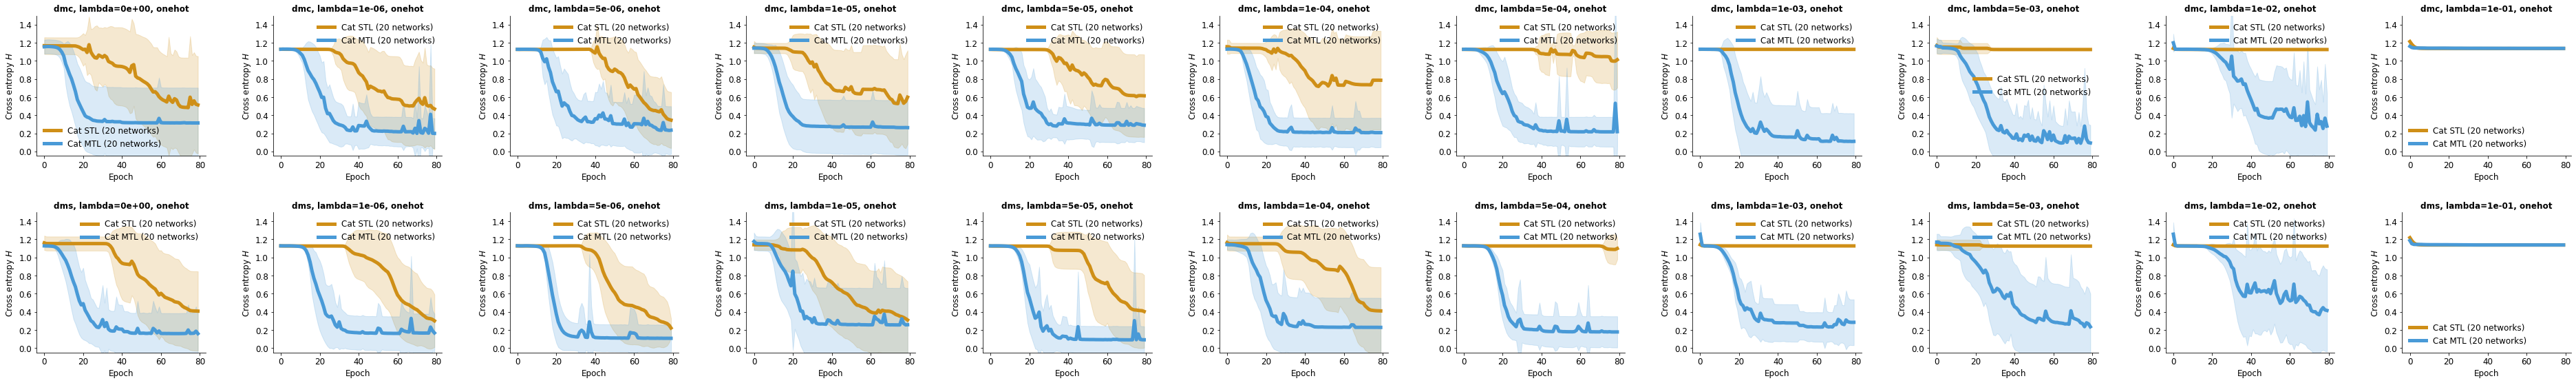

In [124]:
## Show convergence for each sparsity condition:
sparsity_str_arr = ['0e+00', '1e-06', '5e-06', '1e-05', '5e-05', '1e-04', '5e-04', '1e-03', '5e-03', '1e-02', '1e-01']
task_list = ['dmc', 'dms']
# sparsity_str_arr = ['0e+00', '5e-06', '1e-05', '5e-05', '1e-04', '5e-04', '1e-03', '5e-03']
fig, ax = plt.subplots(len(task_list), len(sparsity_str_arr), figsize=(len(sparsity_str_arr) * 6, len(task_list) *4.5), 
                       gridspec_kw={'wspace': 0.4, 'hspace': 0.4})
pr.set_fontsize(12)
for i_spars, spars in enumerate(sparsity_str_arr):
    for i_task, task in enumerate(task_list):
        for i_nat, nat in enumerate(['onehot']):
            prm.plot_effect_eavesdropping_learning(task=task, ratio_exp_str='7525', 
                                                   sparsity_str=spars, nature_stim=nat,
                                                   ax=ax[i_task + 2 * i_nat][i_spars],
                                                   plot_std=True, plot_indiv=False, plot_pred=False,
                                                   plot_legend=True)#(i_spars == 0 and i_task ==0 and i_nat == 0 and False))
            ax[i_task + 2 * i_nat][i_spars].set_title(f'{task}, lambda={spars}, {nat}', 
                                                     fontdict={'weight': 'bold'})
# plt.savefig('figures/learning_efficiency_dmc_dms_periodic_only.pdf', bbox_inches='tight')        

Cutting of DF because of empty rows
Cutting of DF because of empty rows
Cutting of DF because of empty rows
Cutting of DF because of empty rows
Cutting of DF because of empty rows
Cutting of DF because of empty rows


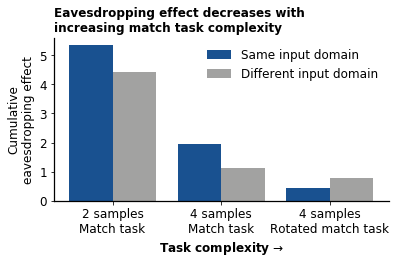

In [3]:
## Figure 3: (and was subsequently merged in inkscape)
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
prm.plot_bar_plot_all_tasks(ax=ax, save_fig=False)

Cutting of DF because of empty rows
Cutting of DF because of empty rows
Cutting of DF because of empty rows
Cutting of DF because of empty rows
Cutting of DF because of empty rows
Cutting of DF because of empty rows
[4.70111328 4.46332621 7.55908912 7.52400027 9.16087792 7.90066323] [10.03439884  8.8820589   9.49832529  8.66621046  9.5977184   8.69025599]


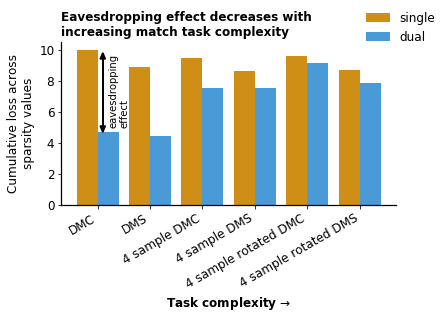

In [7]:
## Figure 3: (and was subsequently merged in inkscape)
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
prm.plot_bar_plot_all_tasks_splitup(ax=ax, save_fig=False)

In [31]:
tmp_df = ru.calculate_all_learning_eff_indices(task_list=['dmc'], nature_stim_list=['periodic'],
                                            method='final_loss', eval_pred_loss_only=True)

Cutting of DF because of empty rows


In [32]:
tmp_df[[x[:4] == 'pred' for x in tmp_df['loss_comp']]].groupby(['task', 'nature_stim', 'setting','sparsity']).mean() 

# tmp_df.groupby(['setting']).sum()
# tmp_df = tmp_df.reset_index()
# tmp_df[tmp_df['setting'] == 'multi']['learning_eff']

learning_eff
task nature_stim setting sparsity              
dmc  periodic    multi   0.000000      0.635356
                         0.000001      0.621998
                         0.000005      0.631286
                         0.000010      0.620247
                         0.000050      0.643398
                         0.000100      0.638333
                         0.000500      0.628459
                         0.001000      0.635170
                         0.005000      0.664473
                         0.010000      0.673490
                         0.050000      1.955791
                         0.100000      2.525834

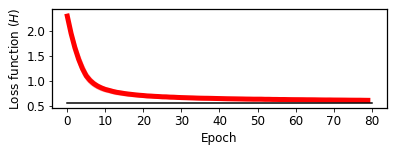

In [24]:

_ = prm.plot_split_perf(rnn_folder='models/7525/dmrc_task/periodic/sparsity_1e-03/pred_only/', list_top=['pred'], lw=5,
                            linestyle_custom_dict={'pred': '-'}, colour_custom_dict={'pred': 'red'},
                            plot_std=True, plot_indiv=False,
                            ax_top=None, ax_bottom=None, plot_bottom=False,
                            label_dict_keys={'pred': 'sadf'}, max_date_bool=True)
plt.plot([0, 80], [0.55, 0.55], c='k')

Cutting of DF because of empty rows
Cutting of DF because of empty rows
Cutting of DF because of empty rows
Cutting of DF because of empty rows
Cutting of DF because of empty rows
Cutting of DF because of empty rows


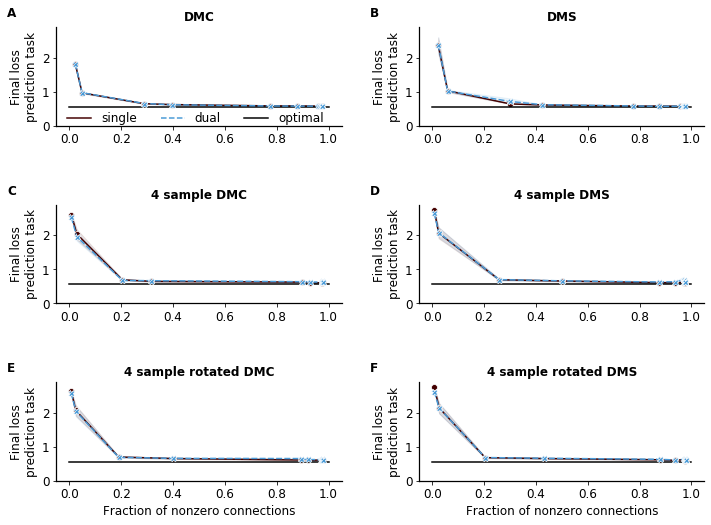

In [91]:
fig = plt.figure(constrained_layout=False, figsize=(9, 7))
gs_left = fig.add_gridspec(ncols=1, nrows=3, bottom=0.05, top=0.95, left=0, right=0.44, wspace=0.7, hspace=0.8)
gs_right = fig.add_gridspec(ncols=1, nrows=3, bottom=0.05, top=0.95, left=0.56, right=1, wspace=0.7, hspace=0.8)

ax_left, ax_right = {}, {}
for ii in range(3):
    ax_left[ii] = fig.add_subplot(gs_left[ii])
    ax_right[ii] = fig.add_subplot(gs_right[ii])
    
method = 'final_loss'    
save_fig = True
plot_nz_axis = True


i_plot = 0
for type_task in ['dmc', 'dmrc', 'dms', 'dmrs']:
    for nature_stim in ['onehot', 'periodic']:
        if nature_stim == 'onehot':
            if 'r' in type_task:
                continue
        if i_plot < 3:
            curr_ax = ax_left[i_plot]
        else:
            curr_ax = ax_right[int(i_plot - 3)]

        if plot_nz_axis:
            nz_df, _, __ = ru.create_nonzero_mapping_df(type_task=type_task, nature_stim=nature_stim)
        else:
            nz_df = None
        df = prm.plot_learning_efficiency(plot_difference=False, method=method, 
                                        task_list=[type_task], nature_stim_list=[nature_stim], ax=curr_ax,
                                        plot_custom_legend=bool_diff if i_plot == 0 else False, 
                                        leg_anchor=(0, 0.25), leg_cols=3,
                                        new_x_axis_df=nz_df, plot_pred_only=True)


        pred_only_colour = [67 / 255, 0, 0]
        pred_spec_colour = [73 / 255, 154 / 255, 215 / 255]
        for chi in list(curr_ax.get_children()):
            if hasattr(chi, '_color') and type(chi._color) != str:
                if np.isclose(np.array(chi._color), np.array(pred_spec_colour)).all():
                    chi.set_zorder(10)

        if 'c' in type_task:
            str_dom = 'DMC'
        else:
            str_dom = 'DMS'
        if 'r' in type_task:
            str_task = 'rotated '
        else:
            str_task = ''
        if nature_stim == 'onehot':
            optimal_pred = -0.25 * (3 * np.log(0.75) + np.log(0.25))
            curr_ax.plot([0, 1 if plot_nz_axis else 0.1], [optimal_pred, optimal_pred], c='k')
            str_samp = ''
        else:
            optimal_pred = 5 / 9
            curr_ax.plot([0, 1 if plot_nz_axis else 0.1], [optimal_pred, optimal_pred], c='k')
            str_samp = '4 sample '
        # curr_ax.set_title(f'{str_task}, {str_samp},\n{str_dom}', loc='left', fontdict={'weight': 'bold'})

        curr_ax.set_title(f'{str_samp}{str_task}{str_dom}', fontdict={'weight': 'bold'})
        i_plot += 1

letters = ['A', 'B', 'C', 'D', 'E' ,'F']
i_let = 0
for ii in range(3):
    for axx in [ax_left, ax_right]:
        axx[ii].set_ylabel('Final loss\nprediction task')
        if ii < 2:
            axx[ii].set_xlabel('')
        axx[ii].set_ylim([0, 2.9])
        axx[ii].text(s=letters[i_let], x=-0.24 if plot_nz_axis else -4e-6, y=3.2, fontdict={'weight': 'bold'})
        i_let += 1
if save_fig:
    plt.savefig('figures/nips/fig3_other-tasks_predictionloss.pdf', bbox_inches='tight')
    

In [73]:
type(chi._color)
# np.array(pred_only_colour)#.all()

str

Cutting of DF because of empty rows


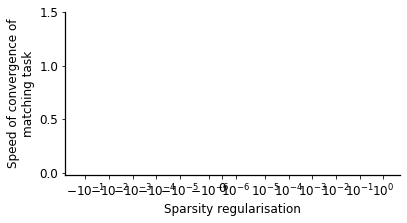

In [34]:
df = prm.plot_learning_efficiency(plot_difference=False,# method=method, 
                                    task_list=['dmc'], nature_stim_list=['onehot'])#,# ax=curr_ax,
                                    # plot_custom_legend=bool_diff if i_plot == 0 else False, 
                                    # leg_anchor=(0, 0.25), leg_cols=3,
                                    # new_x_axis_df=nz_df)


# Figure 4:

In [285]:
## train decoders if needed
bpm.train_multiple_decoders(rnn_folder=folder_rnn)

cpu



0it [00:00, ?it/s]

train labels  {'11': 200, '1x': 200, '22': 200, '2x': 200}


2it [00:03,  1.68s/it]/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
3it [00:05,  1.68s/it]/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
10it [00:18,  1.81s/it]



20it [00:00, 1245.64it/s]

20it [00:00, 1808.98it/s]

20it [00:00, 1891.24it/s]

12it [00:00, 1007.16it/s]

20it [00:00, 1202.10it/s]

20it [00:00, 1247.17it/s]

20it [00:00, 1242.19it/s]

20it [00:00, 686.50it/s]

20it [00:00, 1172.15it/s]

0it [00:00, ?it/s]

s1
s2
go


20it [00:00, 1472.05it/s]

12it [00:00, 672.06it/s]

20it [00:00, 704.26it/s]

20it [00:00, 698.02it/s]

20it [00:00, 680.58it/s]


s1
s2
go


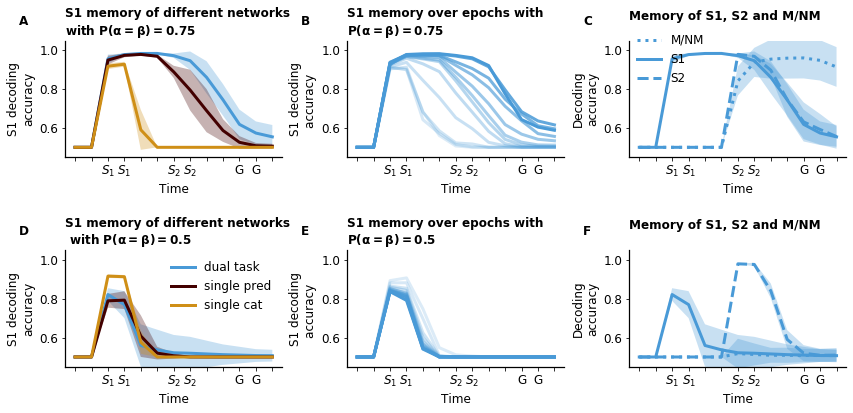

In [328]:
## Instructions on saving the values to make this plot:

## The FIRST RUN, compute everything:

fig, ax = plt.subplots(2, 3, figsize=(14, 6), gridspec_kw={'hspace': 0.8, 'wspace': 0.3})
prm.plot_autotemp_s1_decoding('/home/thijs/repos/rotation/models/7525/dmc_task/onehot/sparsity_1e-03/', ax=ax[0][0], plot_legend=False)

## Set dict to None:
autotemp_dict = prm.plot_autotemp_s1_different_epochs(ax=ax[0][1], plot_legend=False,
                                                      autotemp_dec_mat_dict=None,
                                                     rnn_folder='/home/thijs/repos/rotation/models/save_state/7525/dmc_task/onehot/sparsity_1e-03/pred_dmc/')
## Set reset to True, skip to False:
prm.plot_autotemp_all_reps_decoding(reset_decoders=True, ax=ax[0][2],
                                    skip_if_already_decoded=False,
                                    rnn_folder='/home/thijs/repos/rotation/models/7525/dmc_task/onehot/sparsity_1e-03/pred_dmc/')

prm.plot_autotemp_s1_decoding('/home/thijs/repos/rotation/models/5050/dmc_task/onehot/sparsity_1e-03/', ax=ax[1][0], plot_legend=True)
autotemp_dict_50 = prm.plot_autotemp_s1_different_epochs(ax=ax[1][1], plot_legend=False, 
                                                         autotemp_dec_mat_dict=None,
                                                        rnn_folder='/home/thijs/repos/rotation/models/save_state/5050/dmc_task/onehot/sparsity_1e-03/pred_dmc/')



prm.plot_autotemp_all_reps_decoding(reset_decoders=True, ax=ax[1][2],
                                    skip_if_already_decoded=False, plot_legend=False,
                                    rnn_folder='/home/thijs/repos/rotation/models/5050/dmc_task/onehot/sparsity_1e-03/pred_dmc/')


ax[0][0].set_title('S1 memory of different networks\nwith ' + r'$\mathbf{P(\alpha = \beta)=0.75}$', loc='left', fontdict={'weight': 'bold'})
ax[1][0].set_title('S1 memory of different networks\n with ' + r'$\mathbf{P(\alpha = \beta)=0.5}$', loc='left', fontdict={'weight': 'bold'})
ax[0][1].set_title('S1 memory over epochs with\n' + r'$\mathbf{P(\alpha = \beta)=0.75}$', loc='left', fontdict={'weight': 'bold'})
ax[1][1].set_title('S1 memory over epochs with\n' + r'$\mathbf{P(\alpha = \beta)=0.5}$', loc='left', fontdict={'weight': 'bold'});
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
i_let = 0
for i_row in range(2):
    for i_col in range(3):
        ax[i_row][i_col].text(s=letters[i_let], x=-3.4, y=1.13, fontdict={'weight': 'bold'})
        i_let += 1
        
assert False, 'the code below will make the same plot, it is just there to show how to avoid redoing the computations'
## The SECOND run, reuse existing:

## Reuse dict:
autotemp_dict = prm.plot_autotemp_s1_different_epochs(ax=ax[0][1], plot_legend=False,
                                                      autotemp_dec_mat_dict=autotemp_dict,
                                                     rnn_folder='/home/thijs/repos/rotation/models/save_state/7525/dmc_task/onehot/sparsity_1e-03/pred_dmc/')
## Reset to False ,skip to True:
prm.plot_autotemp_all_reps_decoding(reset_decoders=False, ax=ax[0][2],
                                    skip_if_already_decoded=True,
                                    rnn_folder='/home/thijs/repos/rotation/models/7525/dmc_task/onehot/sparsity_1e-03/pred_dmc/')
prm.plot_autotemp_s1_decoding('/home/thijs/repos/rotation/models/5050/dmc_task/onehot/sparsity_1e-03/', ax=ax[1][0], plot_legend=True)
autotemp_dict_50 = prm.plot_autotemp_s1_different_epochs(ax=ax[1][1], plot_legend=False, 
                                                         autotemp_dec_mat_dict=autotemp_dict_50,
                                                        rnn_folder='/home/thijs/repos/rotation/models/save_state/5050/dmc_task/onehot/sparsity_1e-03/pred_dmc/')
prm.plot_autotemp_all_reps_decoding(reset_decoders=False, ax=ax[1][2],
                                    skip_if_already_decoded=True, plot_legend=False,
                                    rnn_folder='/home/thijs/repos/rotation/models/5050/dmc_task/onehot/sparsity_1e-03/pred_dmc/')




20it [00:00, 1087.16it/s]


20it [00:00, 1287.01it/s]


20it [00:00, 1087.26it/s]


13it [00:00, 788.25it/s]


20it [00:00, 774.26it/s]


20it [00:00, 916.90it/s]


20it [00:00, 495.75it/s]


20it [00:00, 1143.92it/s]


0it [00:00, ?it/s]

s1
s2
go


20it [00:00, 1262.00it/s]


20it [00:00, 812.53it/s]


12it [00:00, 785.68it/s]


20it [00:00, 635.59it/s]


20it [00:00, 642.83it/s]


20it [00:00, 677.95it/s]


s1
s2
go


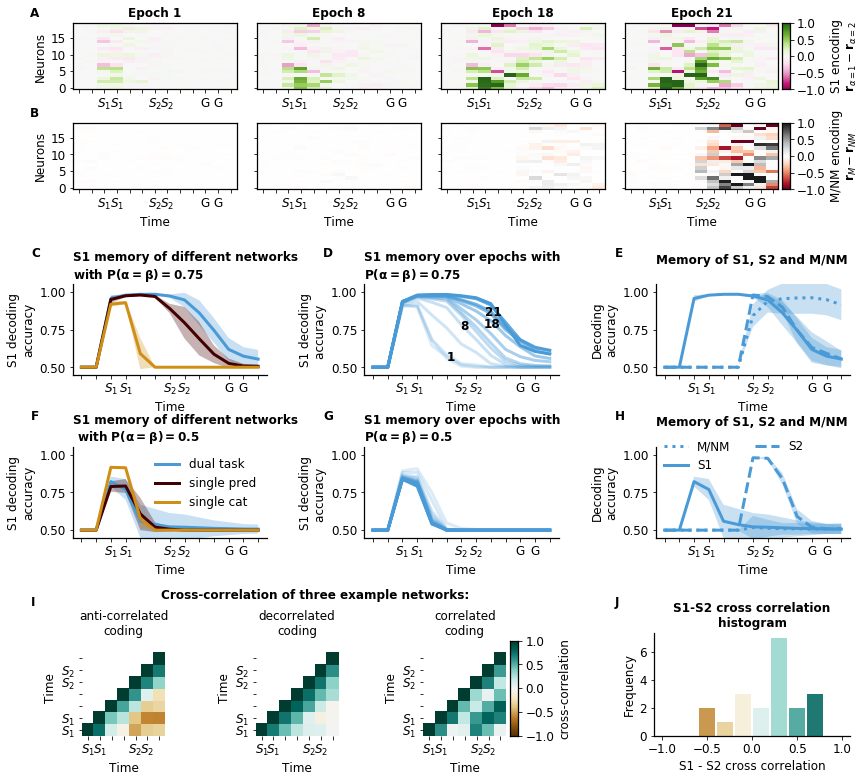

In [456]:
fig = plt.figure(constrained_layout=False, figsize=(12, 11))

epoch_list = [1, 8, 18, 21]
save_fig = False

gs_mat = fig.add_gridspec(ncols=len(epoch_list), nrows=2, bottom=0.74, top=0.95, left=0.05, right=0.88, wspace=0.12, hspace=0.5)
# gs_cbar_mat = fig.add_gridspec(ncols=1, nrows=2, bottom=0.8, top=0.95, left=0.95, right=0.99, wspace=0.0, hspace=0.3)
gs_mem = fig.add_gridspec(ncols=3, nrows=2, bottom=0.3, top=0.62, left=0.05, right=0.95, wspace=0.5, hspace=0.8)
gs_code_mat = fig.add_gridspec(ncols=3, nrows=1, bottom=0.05, top=0.17, left=0.05, right=0.57, wspace=0.7, hspace=0.3)
gs_code_hist = fig.add_gridspec(ncols=1, nrows=1, bottom=0.05, top=0.18, left=0.723, right=0.95, wspace=0.3, hspace=0.3)

ax_mat = {0: {}, 1: {}}
ax_mem = {0: {}, 1: {}}
ax_code_mat = {}
ax_cbar = {}
for i_row in range(2):
#     ax_cbar[i_row] = fig.add_subplot(gs_cbar_mat[i_row])
    for i_col in range(len(epoch_list)):
        ax_mat[i_row][i_col] = fig.add_subplot(gs_mat[i_row, i_col])
    for i_col in range(3):
        ax_mem[i_row][i_col] = fig.add_subplot(gs_mem[i_row, i_col])
for i_col in range(3):
    ax_code_mat[i_col] = fig.add_subplot(gs_code_mat[i_col])
ax_code_hist = fig.add_subplot(gs_code_hist[0])
## Example rasters:
rnn = ru.load_rnn('/home/thijs/repos/rotation/models/save_state/7525/dmc_task/onehot/sparsity_1e-03/pred_dmc/rnn-mnm_2021-05-13-2134.data')
rnn.eval()

## Determine sorting using final solution:
_, __, forw  = bpm.train_single_decoder_new_data(rnn=rnn, ratio_expected=0.5,
                                         sparsity_c=0.1, bool_train_decoder=False)  # just gets data without training decoder
plot_diff, _, __ = ru.calculate_diff_activity(forw=forw, representation='s1')
ol = prm.opt_leaf(plot_diff, dim=0)  # optimal leaf sorting

for i_epoch, epoch in enumerate(epoch_list):
    rnn.load_state_dict(rnn.saved_states_dict[epoch])
    rnn.eval()
    _, __, forw  = bpm.train_single_decoder_new_data(rnn=rnn, ratio_expected=0.5,
                                                 sparsity_c=0.1, bool_train_decoder=False)  # just gets data without training decoder
    for ii, rep in enumerate(['s1', 'go']):
        plot_diff, _, __ = ru.calculate_diff_activity(forw=forw, representation=rep)
        ol = prm.plot_raster_trial_average(plot_diff=plot_diff, ol=ol, ax=ax_mat[ii][i_epoch], representation=rep,
                                           th=1, plot_title=False, c_bar=False)
    
#         ax_mat[i_epoch + 1][ii].set_title(f'Epoch {epoch}, rep {rep}', y=0.75)
        if ii == 1:
            ax_mat[ii][i_epoch].set_xlabel('Time')
        else:
            ax_mat[ii][i_epoch].set_title(f'Epoch {epoch}', fontdict={'weight': 'bold'})
            ax_mat[ii][i_epoch].set_xlabel('')
        if i_epoch == 0:
            ax_mat[ii][i_epoch].set_ylabel('Neurons')
        else:
            ax_mat[ii][i_epoch].set_ylabel('')
            ax_mat[ii][i_epoch].set_yticklabels([])
        for xx in ['top', 'right', 'bottom', 'left']:
            ax_mat[ii][i_epoch].spines[xx].set_visible(True)
            
for ii, rep in enumerate(['s1', 'go']):
    divider = make_axes_locatable(ax_mat[ii][i_epoch])
    ax_cbar[ii] = divider.append_axes('right', size='5%', pad=0.05)
    mpl_colorbar(ax_mat[ii][i_epoch].get_children()[0], cax=ax_cbar[ii])
    ax_cbar[ii].yaxis.set_ticks([-1, -0.5, 0, 0.5, 1])
    ax_cbar[ii].yaxis.set_ticks_position('right')
ax_cbar[0].set_ylabel('S1 encoding\n' + r'$\mathbf{r}_{\alpha=1} - \mathbf{r}_{\alpha=2}$')
ax_cbar[1].set_ylabel('M/NM encoding\n' + r'$\mathbf{r}_{M} - \mathbf{r}_{NM}$')


        
## Memory mechanisms:
prm.plot_autotemp_s1_decoding('/home/thijs/repos/rotation/models/7525/dmc_task/onehot/sparsity_1e-03/', ax=ax_mem[0][0], plot_legend=False)
autotemp_dict = prm.plot_autotemp_s1_different_epochs(ax=ax_mem[0][1], plot_legend=False,
                                                      autotemp_dec_mat_dict=autotemp_dict,
                                                      add_labels=True,
                                                      epoch_list=[1, 2, 4, 6, 8, 10, 12, 15, 18, 20, 21, 25, 40],
                                                     rnn_folder='/home/thijs/repos/rotation/models/save_state/7525/dmc_task/onehot/sparsity_1e-03/pred_dmc/')
prm.plot_autotemp_all_reps_decoding(reset_decoders=False, ax=ax_mem[0][2],
                                    skip_if_already_decoded=True, plot_legend=False,
                                    rnn_folder='/home/thijs/repos/rotation/models/7525/dmc_task/onehot/sparsity_1e-03/pred_dmc/')

prm.plot_autotemp_s1_decoding('/home/thijs/repos/rotation/models/5050/dmc_task/onehot/sparsity_1e-03/', ax=ax_mem[1][0], plot_legend=True)
autotemp_dict_50 = prm.plot_autotemp_s1_different_epochs(ax=ax_mem[1][1], plot_legend=False, 
                                                         autotemp_dec_mat_dict=autotemp_dict_50,
                                                        rnn_folder='/home/thijs/repos/rotation/models/save_state/5050/dmc_task/onehot/sparsity_1e-03/pred_dmc/')



prm.plot_autotemp_all_reps_decoding(reset_decoders=False, ax=ax_mem[1][2],
                                    skip_if_already_decoded=True, plot_legend=True,
                                    rnn_folder='/home/thijs/repos/rotation/models/5050/dmc_task/onehot/sparsity_1e-03/pred_dmc/')


ax_mem[0][0].set_title('S1 memory of different networks\nwith ' + r'$\mathbf{P(\alpha = \beta)=0.75}$', loc='left', fontdict={'weight': 'bold'})
ax_mem[1][0].set_title('S1 memory of different networks\n with ' + r'$\mathbf{P(\alpha = \beta)=0.5}$', loc='left', fontdict={'weight': 'bold'})
ax_mem[0][1].set_title('S1 memory over epochs with\n' + r'$\mathbf{P(\alpha = \beta)=0.75}$', loc='left', fontdict={'weight': 'bold'})
ax_mem[1][1].set_title('S1 memory over epochs with\n' + r'$\mathbf{P(\alpha = \beta)=0.5}$', loc='left', fontdict={'weight': 'bold'});


## Neural code matrices 
irnn_mat_list = [3, 18, 2]
rnn_folder = '/home/thijs/repos/rotation/models/7525/dmc_task/onehot/sparsity_1e-03/pred_dmc/'
rnn_list = ru.get_list_rnns(rnn_folder=rnn_folder)

code_mat_titles = ['anti-correlated\ncoding', 'decorrelated\ncoding', 'correlated\ncoding']
for i_plot, i_rnn in enumerate(irnn_mat_list):
    rnn = ru.load_rnn(os.path.join(rnn_folder, rnn_list[i_rnn]))
    rnn.eval()
    prm.plot_correlation_matrix(rnn=rnn, representation='s1', ax=ax_code_mat[i_plot],
                               plot_cbar=False)
    ax_code_mat[i_plot].set_title(code_mat_titles[i_plot])#, fontdict={'weight': 'bold'})

divider = make_axes_locatable(ax_code_mat[i_plot])
ax_cbar_code = divider.append_axes('right', size='10%', pad=0.05)
mpl_colorbar(ax_code_mat[i_plot].get_children()[0], cax=ax_cbar_code)
ax_cbar_code.yaxis.set_ticks([-1, -0.5, 0, 0.5, 1])
ax_cbar_code.yaxis.set_ticks_position('right')
ax_cbar_code.set_ylabel('cross-correlation')

ax_code_mat[1].text(s='Cross-correlation of three example networks:', x=5, y=11.5, fontdict={'weight': 'bold', 'ha': 'center'})

prm.plot_hist_rot_indices(rnn_folder=rnn_folder, ax=ax_code_hist)
ax_code_hist.set_title('S1-S2 cross correlation\nhistogram', fontdict={'weight': 'bold'})
    
letters = ['C', 'D', 'E', 'F', 'G', 'H']
i_let = 0
for i_row in range(2):
    for i_col in range(3):
        ax_mem[i_row][i_col].text(s=letters[i_let], x=-3.4, y=1.23, fontdict={'weight': 'bold'})
        i_let += 1
ax_mem[1][0].text(s='I', x=-3.4, y=0, fontdict={'weight': 'bold'})
ax_mem[1][2].text(s='J', x=-3.4, y=0, fontdict={'weight': 'bold'})
ax_mat[0][0].text(s='A', x=-3.4, y=21.8, fontdict={'weight': 'bold'})
ax_mat[1][0].text(s='B', x=-3.4, y=21.8, fontdict={'weight': 'bold'})

if save_fig:
    plt.savefig('figures/nips/fig4_mechanisms_v2.pdf', bbox_inches='tight')



0it [00:00, ?it/s]


KeyError: 21

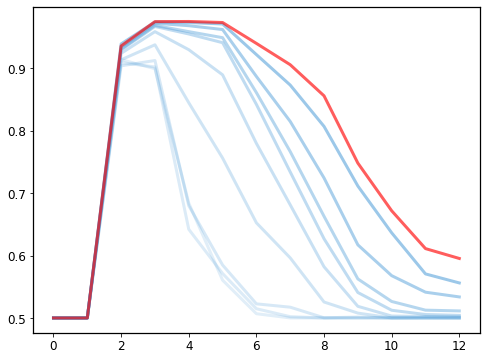

In [437]:
# Check which epoch is which by setting to red one by one (see commented color in prm.plot_autotemp_s1_different_epochs())
autotemp_dict = prm.plot_autotemp_s1_different_epochs(plot_legend=False, add_labels=True,
                                                      autotemp_dec_mat_dict=autotemp_dict,
                                                     rnn_folder='/home/thijs/repos/rotation/models/save_state/7525/dmc_task/onehot/sparsity_1e-03/pred_dmc/')

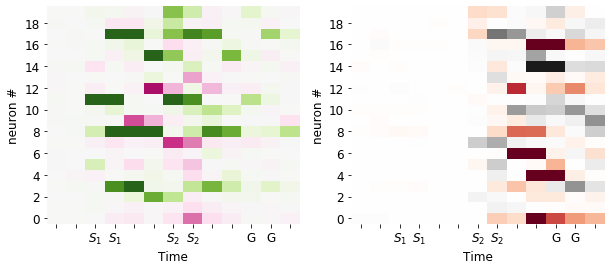

In [463]:
## Check matrices of individual RNNs (that are used for correlatoin mat examples)
irnn_mat_list = [3, 18, 2]
rnn_folder = '/home/thijs/repos/rotation/models/7525/dmc_task/onehot/sparsity_1e-03/pred_dmc/'
rnn_list = ru.get_list_rnns(rnn_folder=rnn_folder)

rnn = ru.load_rnn(os.path.join(rnn_folder, rnn_list[2]))
_, __, forw  = bpm.train_single_decoder_new_data(rnn=rnn, ratio_expected=0.5,
                                                 sparsity_c=0.1, bool_train_decoder=False)  # just gets data without training decoder

fig, ax_mat = plt.subplots(1, 2, figsize=(10, 4))
for ii, rep in enumerate(['s1', 'go']):
    plot_diff, _, __ = ru.calculate_diff_activity(forw=forw, representation=rep)
    ol = prm.plot_raster_trial_average(plot_diff=plot_diff, ol=ol, ax=ax_mat[ii], representation=rep,
                                       th=1, plot_title=False, c_bar=False)

#  

(10, 32)

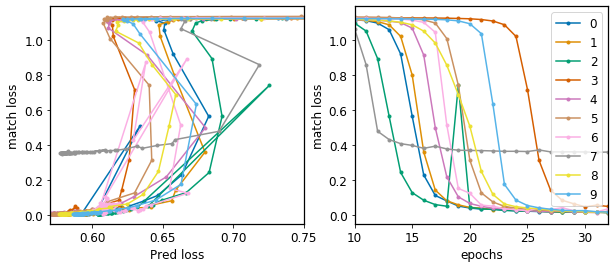

In [476]:
## State space of prediction loss vs match loss:

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
folder_rnn = '/home/thijs/repos/rotation/models/7525/dmc_task/onehot/sparsity_1e-03/pred_dmc/'
list_rnns = [x for x in os.listdir(folder_rnn) if ru.timestamp_max_date(rnn_name=x)]

for i_rnn in range(0, 10):
    filename = list_rnns[i_rnn]
    rnn = ru.load_rnn(os.path.join(folder_rnn, filename))

    ax[0].plot(rnn.test_loss_split['pred'], rnn.test_loss_split['dmc'], '.-')
    ax[1].plot(rnn.test_loss_split['dmc'], '.-', label=i_rnn)
    
ax[0].set_xlabel('Pred loss')
ax[0].set_ylabel('match loss')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('match loss')
ax[1].legend()

ax[0].set_xlim([0.57, 0.75])
# ax[0].set_ylim([0.95, 1.24])
ax[1].set_xlim([10, 32])

(0.55, 0.7)

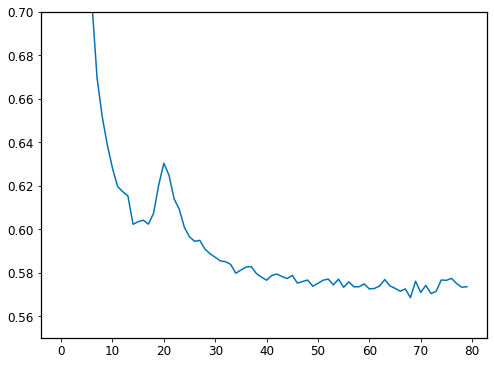

In [294]:
## S2 pred loss is slightly increased when match converges
plt.plot(rnn.test_loss_split['S2'])
plt.ylim([0.55, 0.7])



0it [00:00, ?it/s]

220




1it [00:01,  1.36s/it]

2it [00:02,  1.37s/it]

3it [00:04,  1.44s/it]

4it [00:06,  1.56s/it]

5it [00:07,  1.61s/it]

6it [00:09,  1.60s/it]

7it [00:11,  1.65s/it]

8it [00:13,  1.71s/it]

9it [00:14,  1.68s/it]

10it [00:16,  1.64s/it]

11it [00:17,  1.60s/it]

12it [00:19,  1.56s/it]

13it [00:20,  1.54s/it]

14it [00:22,  1.52s/it]

15it [00:23,  1.51s/it]

16it [00:25,  1.49s/it]

17it [00:26,  1.51s/it]

18it [00:28,  1.50s/it]

19it [00:29,  1.49s/it]

20it [00:31,  1.49s/it]

21it [00:32,  1.49s/it]

22it [00:34,  1.49s/it]

23it [00:35,  1.48s/it]

24it [00:37,  1.48s/it]

25it [00:38,  1.48s/it]

26it [00:39,  1.48s/it]

27it [00:41,  1.48s/it]

28it [00:42,  1.48s/it]

29it [00:44,  1.48s/it]

30it [00:45,  1.48s/it]

31it [00:47,  1.48s/it]

32it [00:48,  1.48s/it]

33it [00:50,  1.48s/it]

34it [00:51,  1.48s/it]

35it [00:53,  1.48s/it]

36it [00:54,  1.48s/it]

37it [00:56,  1.47s/it]

38it [00:57,  1.47s/it]

39it [00:59,  1.53s/it]

40it [01:00,  1.52s/it]

41it [0

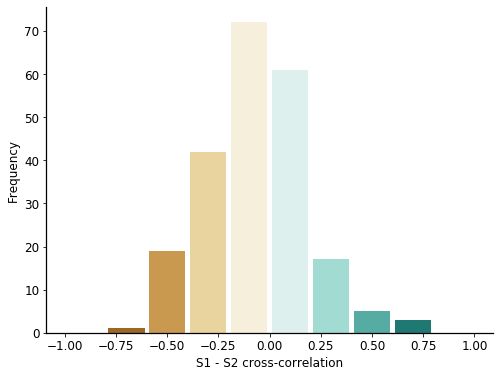

In [474]:
## histogram with 200 networks, BUT NOT SURE IF SIMULATIONS ARE CORRECT

ax = plt.subplot(111)
# prm.plot_hist_rot_indices(rnn_folder='models/7525/dmc_task/onehot/sparsity_1e-03/pred_only', ax=ax)
# prm.plot_hist_rot_indices(rnn_folder='models/7525/dmc_task/onehot/sparsity_1e-03/dmc_only', ax=ax)
tmp2 = prm.plot_hist_rot_indices(rnn_folder='models/7525/dmc_task/onehot/sparsity_1e-03/pred_dmc', ax=ax)

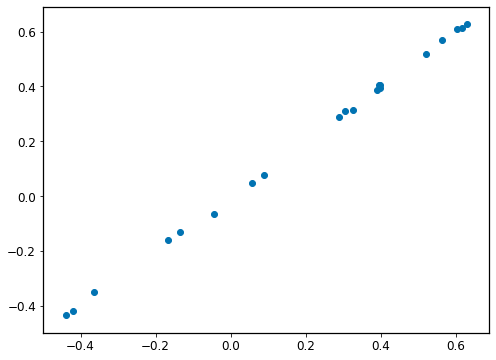

In [473]:
## Note that rotational index can slightly vary, based on what data you use. (ie randomly creating data each run induces slight variation between iterations of plot.) But this is very small, see this plot (diff between 2 iterations)
plt.scatter(tmp, tmp2)

weight sorting not defined
weight sorting not defined
weight sorting not defined


(<Figure size 1008x216 with 6 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd80b144278>,
       dtype=object))

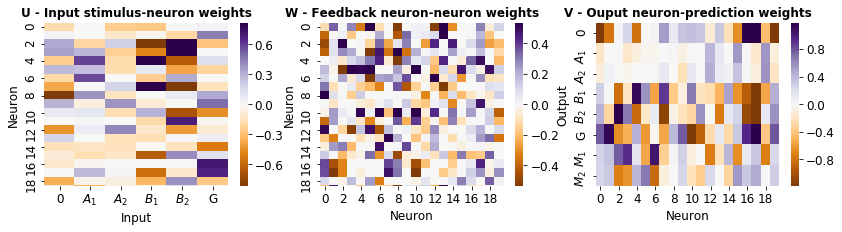

In [278]:
## Plot weights:
prm.plot_all_UWVT(rnn_model=rnn)



0it [00:00, ?it/s]

1it [00:02,  2.07s/it]

2it [00:04,  2.04s/it]

3it [00:06,  2.04s/it]

4it [00:08,  2.03s/it]

5it [00:10,  2.02s/it]

6it [00:12,  2.06s/it]

7it [00:14,  2.05s/it]

8it [00:16,  2.03s/it]

9it [00:18,  2.03s/it]

10it [00:20,  2.03s/it]

11it [00:22,  2.03s/it]

12it [00:24,  2.03s/it]

13it [00:26,  2.04s/it]

14it [00:28,  2.15s/it]

15it [00:31,  2.21s/it]

16it [00:33,  2.23s/it]

17it [00:35,  2.28s/it]

18it [00:38,  2.25s/it]

19it [00:40,  2.24s/it]

20it [00:43,  2.20s/it]


[ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 12 15 16 17 18 19]


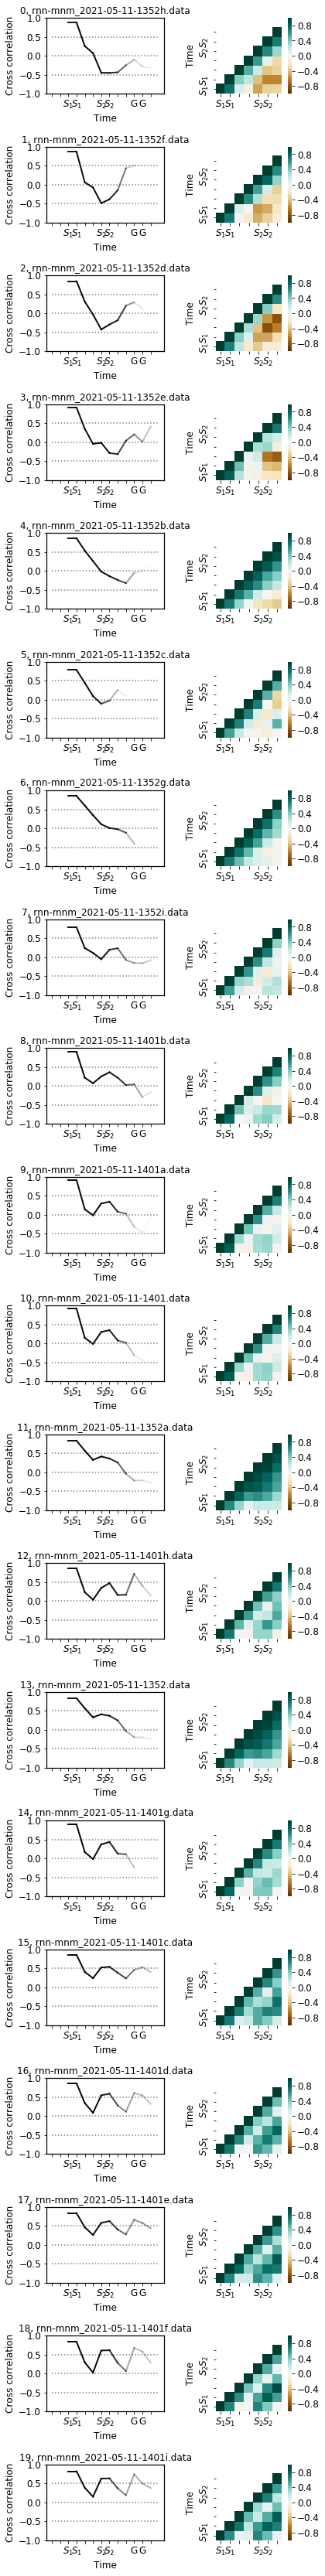

In [404]:
## Plot neural code as 1D line 
prm.plot_example_codes(one_ax=False, sorting_rnns=[3, 19, 13, 6, 9, 16, 18, 10, 1, 4, 11, 17, 8, 7, 14, 0, 12, 15, 5, 2])

## Check one RNN:

In [363]:
_, __, forw  = bpm.train_single_decoder_new_data(rnn=rnn, ratio_expected=0.5,
                                                 sparsity_c=0.1, bool_train_decoder=False)  # just gets data without training decoder


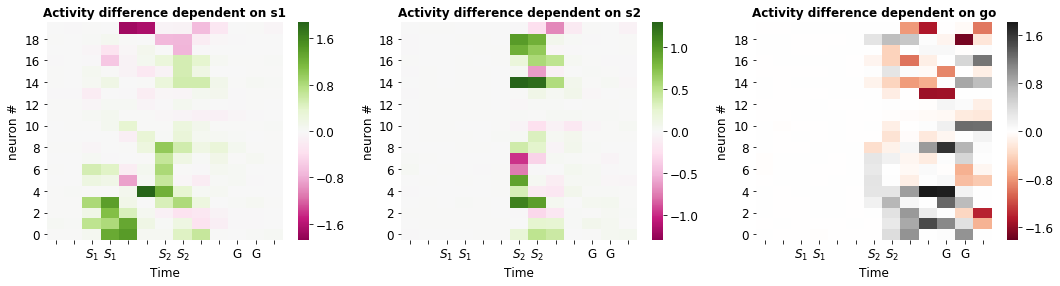

In [379]:
## End result represntation
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

for ii, rep in enumerate(['s1', 's2', 'go']):
    plot_diff, _, __ = ru.calculate_diff_activity(forw=forw, representation=rep)
    ol = prm.plot_raster_trial_average(plot_diff=plot_diff, ol=ol, ax=ax[ii], representation=rep)

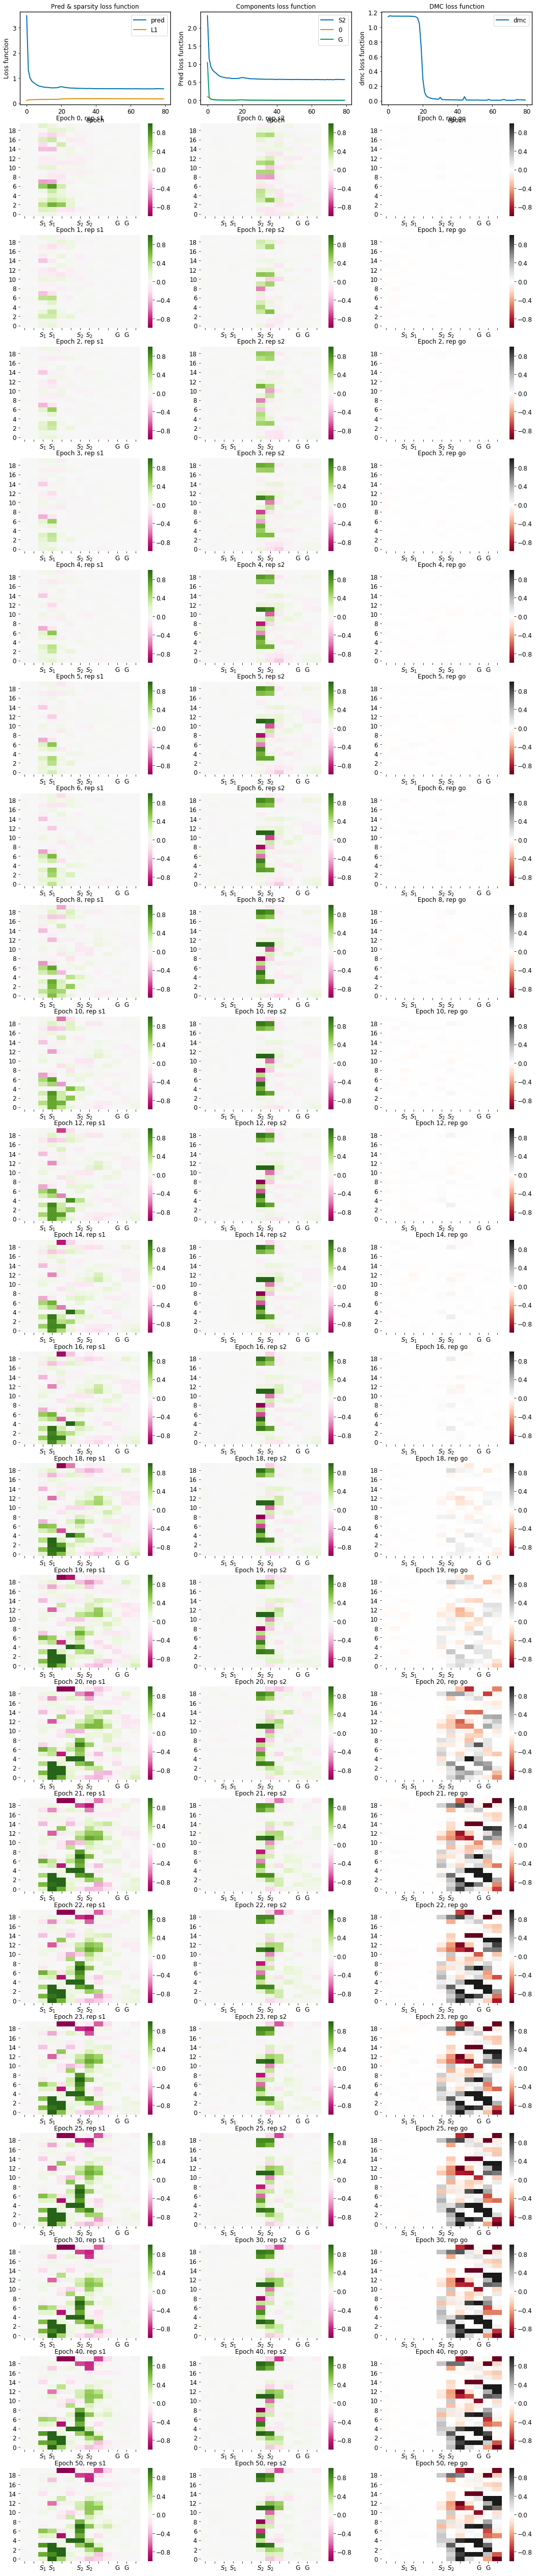

In [298]:
## How do reps vary during learning? (Needs a RNN that saves state_dict during training)
rnn = ru.load_rnn('/home/thijs/repos/rotation/models/save_state/7525/dmc_task/onehot/sparsity_1e-03/pred_dmc/rnn-mnm_2021-05-13-2134.data')
rnn.eval()

epoch_list = [0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 18, 19, 20, 21, 22, 23, 25, 30, 40, 50]


fig, ax = plt.subplots(len(epoch_list) + 1, 3, figsize=(18, 4 * len(epoch_list) + 4))

## Determine sorting using final solution:
_, __, forw  = bpm.train_single_decoder_new_data(rnn=rnn, ratio_expected=0.5,
                                         sparsity_c=0.1, bool_train_decoder=False)  # just gets data without training decoder
plot_diff, _, __ = ru.calculate_diff_activity(forw=forw, representation='s1')
ol = prm.opt_leaf(plot_diff, dim=0)  # optimal leaf sorting
        


for i_epoch, epoch in enumerate(epoch_list):
    rnn.load_state_dict(rnn.saved_states_dict[epoch])
    rnn.eval()
    _, __, forw  = bpm.train_single_decoder_new_data(rnn=rnn, ratio_expected=0.5,
                                                 sparsity_c=0.1, bool_train_decoder=False)  # just gets data without training decoder
    for ii, rep in enumerate(['s1', 's2', 'go']):
        plot_diff, _, __ = ru.calculate_diff_activity(forw=forw, representation=rep)
        ol = prm.plot_raster_trial_average(plot_diff=plot_diff, ol=ol, ax=ax[i_epoch + 1][ii], representation=rep,
                                           th=1, plot_title=False)
    
        ax[i_epoch + 1][ii].set_title(f'Epoch {epoch}, rep {rep}', y=0.75)
        ax[i_epoch + 1][ii].set_xlabel('')
        ax[i_epoch + 1][ii].set_ylabel('')


ax[0][0].plot(rnn.test_loss_split['pred'], linewidth=2, label='pred')
ax[0][0].plot(rnn.test_loss_split['L1'], linewidth=2, label='L1')
ax[0][0].set_xlabel('epoch')
ax[0][0].set_ylabel('Loss function')
ax[0][0].set_title('Pred & sparsity loss function')
ax[0][0].legend()



ax[0][1].plot(rnn.test_loss_split['S2'], linewidth=2, label='S2')
ax[0][1].plot(rnn.test_loss_split['0'], linewidth=2, label='0')
ax[0][1].plot(rnn.test_loss_split['G'], linewidth=2, label='G')
ax[0][1].set_xlabel('epoch')
ax[0][1].set_ylabel('Pred loss function')
ax[0][1].set_title('Components loss function')
ax[0][1].legend()

        
ax[0][2].plot(rnn.test_loss_split['dmc'], linewidth=2, label='dmc')
ax[0][2].set_xlabel('epoch')
ax[0][2].set_ylabel('dmc loss function')
ax[0][2].set_title('DMC loss function')
ax[0][2].legend()

# plt.savefig('figures/nips/rasters_per_epoch.pdf', bbox_inches='tight')


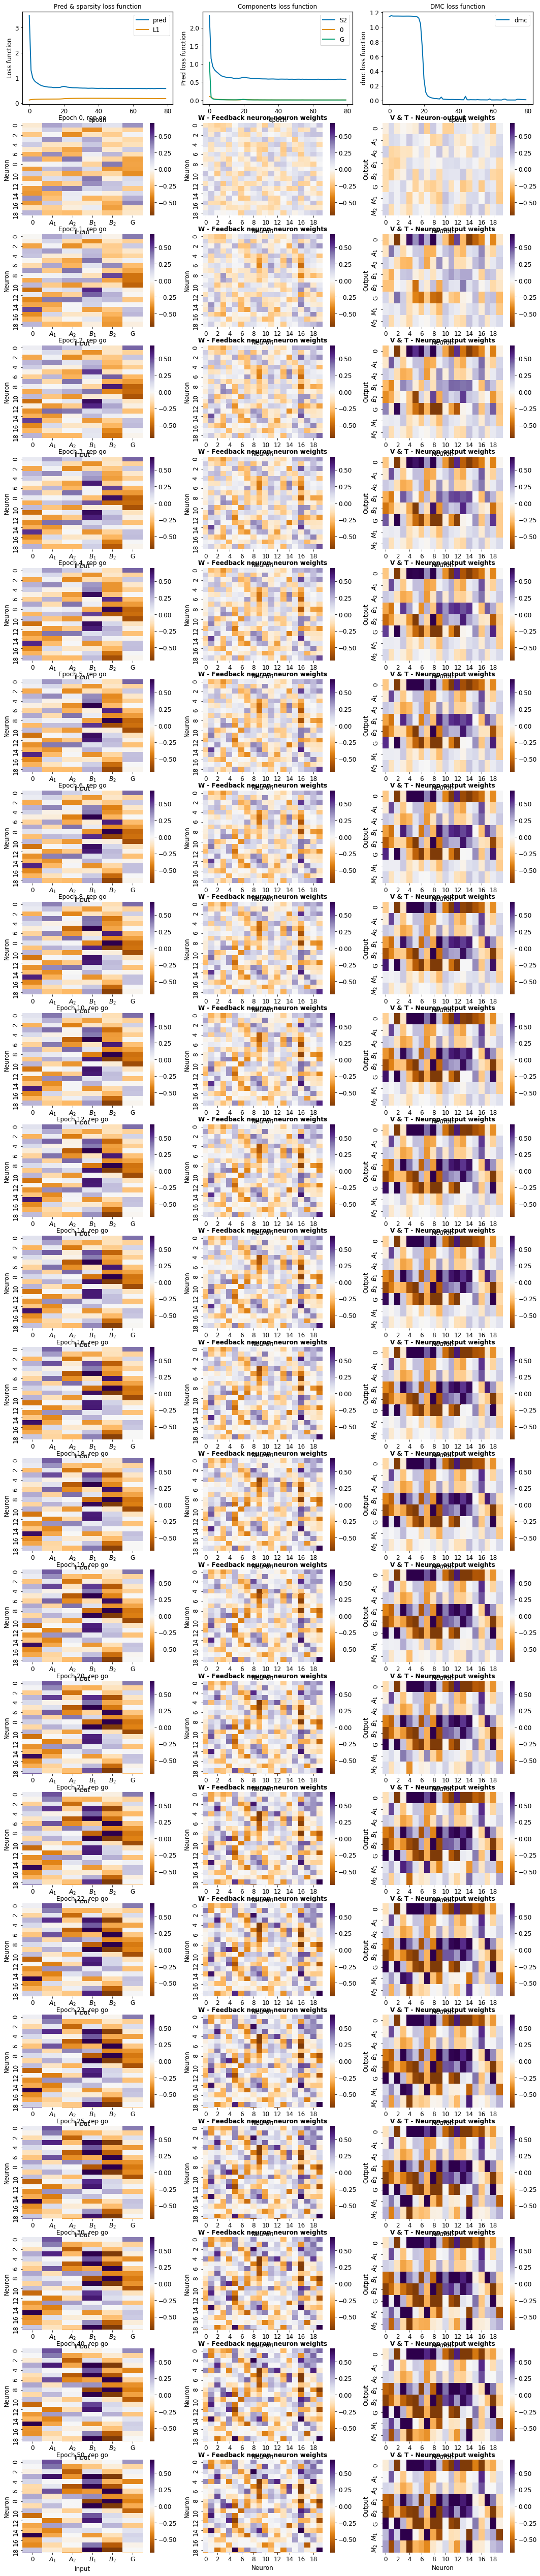

In [292]:
## And how do weights change?
rnn = ru.load_rnn('/home/thijs/repos/rotation/models/save_state/7525/dmc_task/onehot/sparsity_1e-03/pred_dmc/rnn-mnm_2021-05-13-2134.data')
rnn.eval()

epoch_list = [0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 18, 19, 20, 21, 22, 23, 25, 30, 40, 50]


fig, ax = plt.subplots(len(epoch_list) + 1, 3, figsize=(18, 4 * len(epoch_list) + 4))

## Determine sorting using final solution:
_, __, forw  = bpm.train_single_decoder_new_data(rnn=rnn, ratio_expected=0.5,
                                         sparsity_c=0.1, bool_train_decoder=False)  # just gets data without training decoder
plot_diff, _, __ = ru.calculate_diff_activity(forw=forw, representation='s1')
ol = prm.opt_leaf(plot_diff, dim=0)  # optimal leaf sorting
        


for i_epoch, epoch in enumerate(epoch_list):
    rnn.load_state_dict(rnn.saved_states_dict[epoch])
    rnn.eval()
    prm.plot_all_UWVT(rnn_model=rnn, ax_w=ax[i_epoch + 1], th=0.7, weight_order=ol)
    ax[i_epoch + 1][0].set_title(f'Epoch {epoch}, rep {rep}', y=0.75)
#         ax[i_epoch + 1][ii].set_xlabel('')
#         ax[i_epoch + 1][ii].set_ylabel('')


ax[0][0].plot(rnn.test_loss_split['pred'], linewidth=2, label='pred')
ax[0][0].plot(rnn.test_loss_split['L1'], linewidth=2, label='L1')
ax[0][0].set_xlabel('epoch')
ax[0][0].set_ylabel('Loss function')
ax[0][0].set_title('Pred & sparsity loss function')
ax[0][0].legend()



ax[0][1].plot(rnn.test_loss_split['S2'], linewidth=2, label='S2')
ax[0][1].plot(rnn.test_loss_split['0'], linewidth=2, label='0')
ax[0][1].plot(rnn.test_loss_split['G'], linewidth=2, label='G')
ax[0][1].set_xlabel('epoch')
ax[0][1].set_ylabel('Pred loss function')
ax[0][1].set_title('Components loss function')
ax[0][1].legend()

        
ax[0][2].plot(rnn.test_loss_split['dmc'], linewidth=2, label='dmc')
ax[0][2].set_xlabel('epoch')
ax[0][2].set_ylabel('dmc loss function')
ax[0][2].set_title('DMC loss function')
ax[0][2].legend()

# plt.savefig('figures/nips/rasters_per_epoch.pdf', bbox_inches='tight')


## Compare different decoders:
- Logistic regression
- LDA
- Cross correlatoin

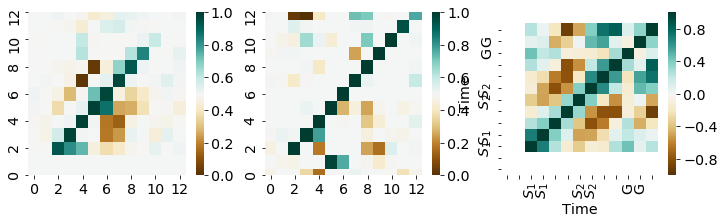

In [126]:
rnn = ru.load_rnn('models/7525/dmc_task/onehot/sparsity_1e-03/pred_dmc/rnn-mnm_2021-05-11-1352d.data')
sm, _, __ = bpm.train_single_decoder_new_data(rnn=rnn, decoder_type='LDA', 
                                              save_inplace=False)

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
sns.heatmap(rnn.decoding_crosstemp_score['s1'], cmap='BrBG', vmin=0, vmax=1, ax=ax[0])
ax[0].invert_yaxis()


sns.heatmap(sm, cmap='BrBG', vmin=0, vmax=1, ax=ax[1])
ax[1].invert_yaxis()

prm.plot_correlation_matrix(rnn=rnn, representation='s1', ax=ax[2])

# Figure 5:

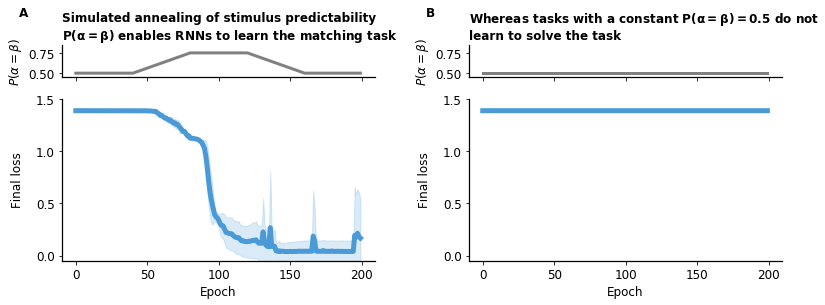

In [452]:
_ = prm.plot_sa_convergence(plot_indiv=False, sa_folder_list=['/home/thijs/repos/rotation/models/simulated_annealing/7525/dmc_task/onehot/sparsity_1e-03/pred_dmc', '/home/thijs/repos/rotation/models/simulated_annealing/5050/dmc_task/onehot/sparsity_1e-03/pred_dmc'])
# plt.savefig('figures/nips/fig5-simulated-annealing.pdf', bbox_inches='tight')

In [ ]:
_ = prm.plot_sa_convergence_small(plot_indiv=False, sa_folder_list=['/home/thijs/repos/rotation/models/simulated_annealing/7525/dmc_task/onehot/sparsity_1e-03/pred_dmc', '/home/thijs/repos/rotation/models/simulated_annealing/5050/dmc_task/onehot/sparsity_1e-03/pred_dmc'])
plt.savefig('figures/fig3-simulated-annealing.svg', bbox_inches='tight')